In [55]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [56]:
#Load sales of smartphones in India (Rupee)
data = pd.read_csv("Sales.csv")
data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8 GB,128 GB,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2 GB,16 GB,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
2,realme,C2,Diamond Black,2 GB,NaN,Yes,4.4,6999,7999,realme C2,1000,12.501563
3,Infinix,Note 5,Ice Blue,4 GB,64 GB,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4GB,64 GB,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000


In [57]:
data.dtypes

Brands                  object
Models                  object
Colors                  object
Memory                  object
Storage                 object
Camera                  object
Rating                 float64
Selling Price            int64
Original Price           int64
Mobile                  object
Discount                 int64
discount percentage    float64
dtype: object

In [58]:
data.describe()

,Rating,Selling Price,Original Price,Discount,discount percentage
count,2970.000000,3114.000000,3114.000000,3114.000000,3114.000000
mean,4.243098,26436.625562,28333.473025,1896.847463,6.086788
std,0.271991,30066.892622,31525.599889,5337.126176,11.106776
min,2.300000,1000.000000,1000.000000,-8000.000000,-160.320641
25%,4.100000,9990.000000,10030.250000,0.000000,0.000000
50%,4.300000,15000.000000,16889.500000,0.000000,0.000000
75%,4.400000,28999.000000,31500.000000,2000.000000,9.836388
max,5.000000,179900.000000,189999.000000,75000.000000,70.610305


In [59]:
data.shape

(3114, 12)

discount percentage    0.049209
Discount               0.351638
Rating                 0.451354
Selling Price          0.986097
Original Price         1.000000
Name: Original Price, dtype: float64


<Axes: >

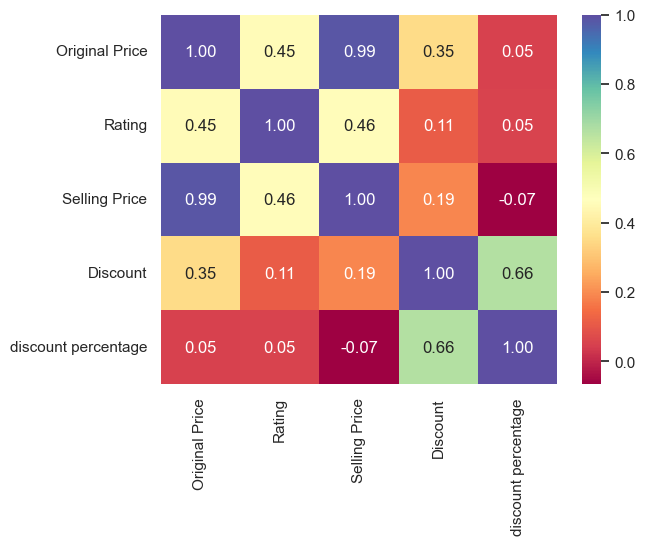

In [60]:
numeric_data = pd.DataFrame(data[["Original Price","Rating", "Selling Price", "Discount", "discount percentage"]])
corr = numeric_data.corr()

# Pearson Correlation Coefficient 
# measures the strength and direction of the relationship between the predictor and response variables
print(corr['Original Price'].sort_values())
sb.heatmap(corr, annot=True, cmap="Spectral", fmt='.2f')

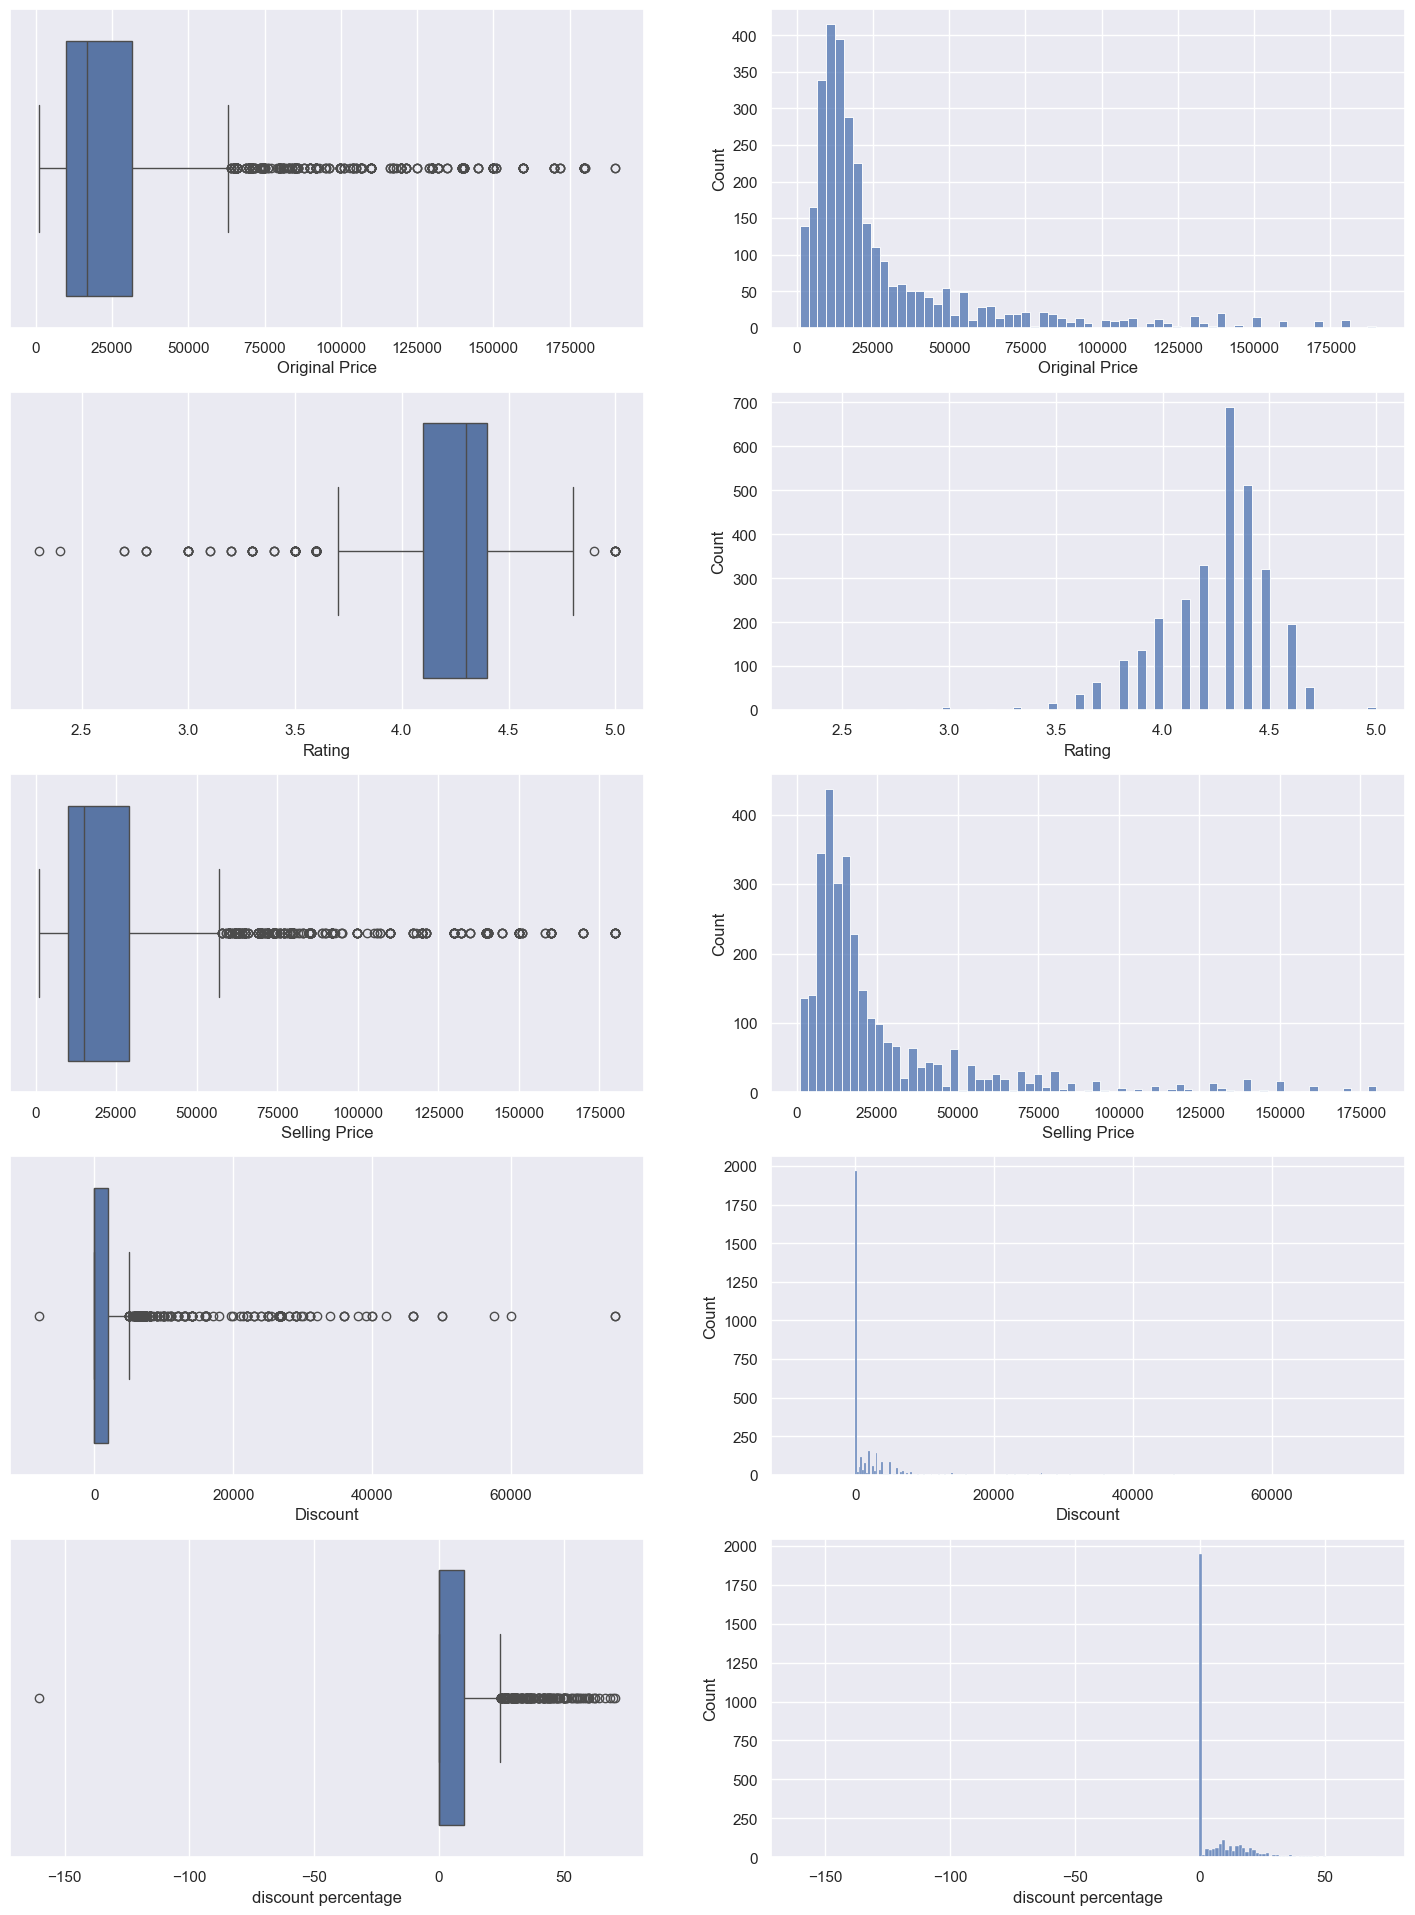

In [61]:
### Boxplots of numeric variables

var = ["Original Price", "Rating", "Selling Price", "Discount", "discount percentage"]
f, axes = plt.subplots(5,2, figsize=(18,24))

count = 0

for var in numeric_data:
    sb.boxplot(data=numeric_data[var], orient="h", ax = axes[count,0])
    sb.histplot(data = numeric_data[var], ax = axes[count,1])
    count += 1

In [62]:
#Calculate outliers
Q1 = data['Original Price'].quantile(0.25)
Q3 = data['Original Price'].quantile(0.75)

IQR = Q3-Q1

lowerBound = Q1-(1.5*IQR)
upperBound = Q3+(1.5*IQR)

#identify all outliers

outliers = data[(data['Original Price'] < lowerBound) | (data['Original Price']> upperBound)]

print("Number of outliers in Original Selling Price: {}".format(len(outliers)))

# data = data.query("Brands == 'Apple'")

Number of outliers in Original Selling Price: 345


In [63]:
#Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    
    lowerBound = Q1-(1.5*IQR)
    upperBound = Q3+(1.5*IQR)
    
    df_filtered = df.loc[(df[column] >= lowerBound) & (df[column] <= upperBound)]
    
    return df_filtered


# Remove outliers in the original selling price
filtered_data = remove_outliers(data, "Original Price")
#df[df['Brands'].str.contains("Apple")].head(400)

In [64]:
#Count the number of null values in the data
filtered_data.isna().sum()

Brands                  0
Models                  0
Colors                  0
Memory                 29
Storage                36
Camera                  0
Rating                 85
Selling Price           0
Original Price          0
Mobile                  0
Discount                0
discount percentage     0
dtype: int64

In [65]:
#Remove all the null values in the data
filtered_data = filtered_data.dropna()

In [66]:
#After the removal of null values
filtered_data.shape

(2625, 12)

In [67]:
filtered_data['Storage'] = filtered_data['Storage'].str.replace("Expandable Upto", "")

In [68]:
#filtered_data["Memory"] = filtered_data['Memory'].str.replace('GB', " GB")
#filtered_data = filtered_data.reset_index()

#Convert to GB
def convert_to_gb(size_str):
    if "MB" in size_str:
        return float(size_str.replace("MB", "")) / 1000
    elif "TB" in size_str:
        return float(size_str.replace("TB", "")) * 1000
    elif "GB" in size_str:
        return float(size_str.replace("GB", ""))
    else:
        return None


filtered_data["Memory"] = filtered_data['Memory'].apply(convert_to_gb)
filtered_data['Storage'] = filtered_data['Storage'].apply(convert_to_gb)
filtered_data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8.000,128.000,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2.000,16.000,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
3,Infinix,Note 5,Ice Blue,4.000,64.000,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4.000,64.000,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000
5,GIONEE,L800,Black,0.008,0.016,Yes,4.0,2199,2199,GIONEE L800,0,0.000000


In [69]:
filtered_data.dtypes

Brands                  object
Models                  object
Colors                  object
Memory                 float64
Storage                float64
Camera                  object
Rating                 float64
Selling Price            int64
Original Price           int64
Mobile                  object
Discount                 int64
discount percentage    float64
dtype: object

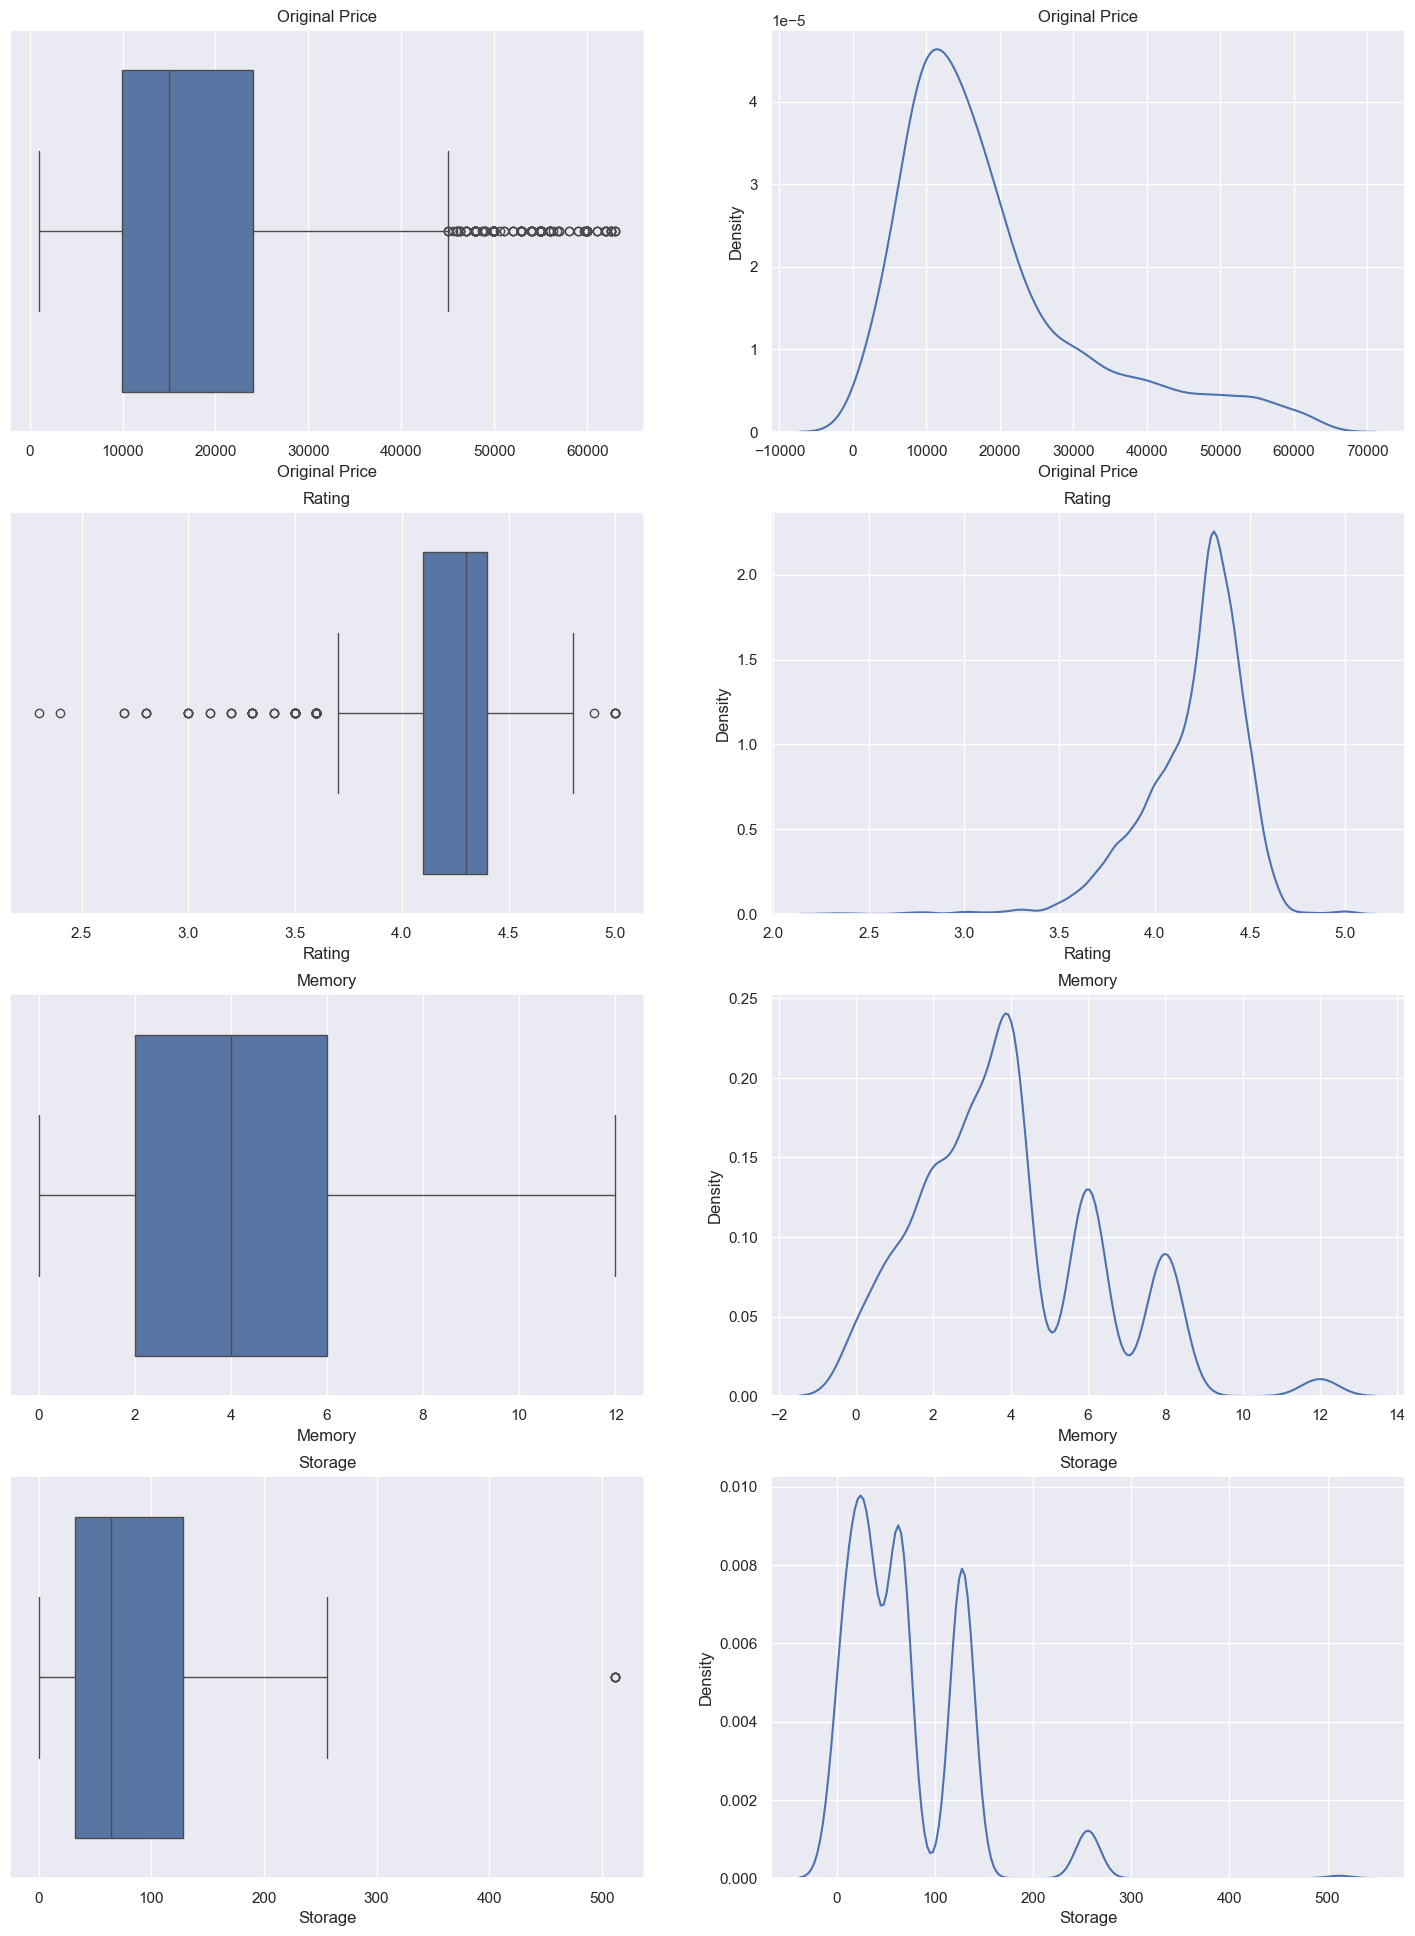

In [70]:
var = ["Original Price", "Rating", "Memory", "Storage"]
filtered_numeric_data = pd.DataFrame(filtered_data[["Original Price","Rating", "Memory", "Storage"]])
count = 0

f, axes = plt.subplots(4,2, figsize=(18,24))
for var in filtered_numeric_data:
    sb.boxplot(data = filtered_numeric_data[var], orient="h", ax = axes[count,0]).set_title(var)
    sb.kdeplot(data=filtered_numeric_data[var], ax = axes[count,1]).set_title(var)
    count+=1

Rating            0.417703
Memory            0.467205
Storage           0.540914
Original Price    1.000000
Name: Original Price, dtype: float64


<Axes: >

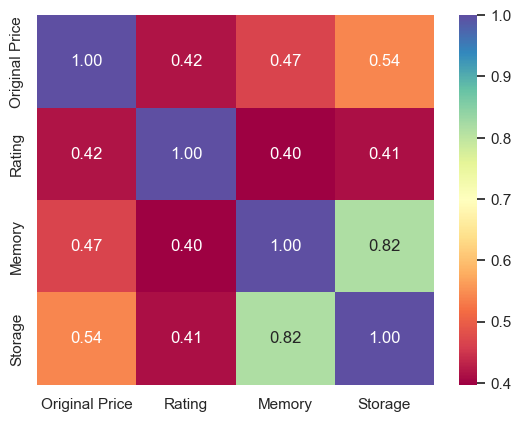

In [71]:
corr = filtered_numeric_data.corr()
print(corr['Original Price'].sort_values())
sb.heatmap(corr, annot=True, cmap="Spectral", fmt='.2f')

The relatively higher correlation coefficients of "Memory" (=0.47) and "Storage" (=0.54) variables with "Original Price" suggest that a decent linear regression model based on "Memory"/"Storage" as the predictor variables and "Original Price" as the response variable could be trained from the dataset  

Coefficients of Regression: 116.70110298458958
Intercept of Regression: 11228.957657891031


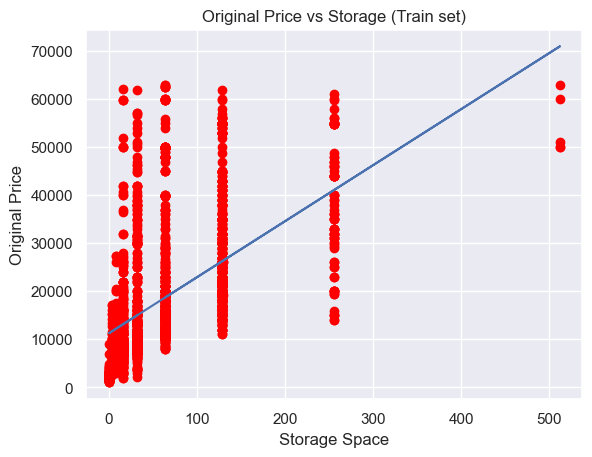

In [72]:
#Linear  Regression
storage = filtered_data[['Storage']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
storage_train, storage_test, originalPrice_train, originalPrice_test = train_test_split(storage, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(storage_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(storage_train, originalPrice_train, color='red')
plt.plot(storage_train, linreg.predict(storage_train))
plt.title("Original Price vs Storage (Train set)")
plt.xlabel('Storage Space')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.284513027527559
Mean Squared Error (MSE): 128185676.25456727

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.3242063843918954
Mean Squared Error (MSE): 108259300.10376182


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

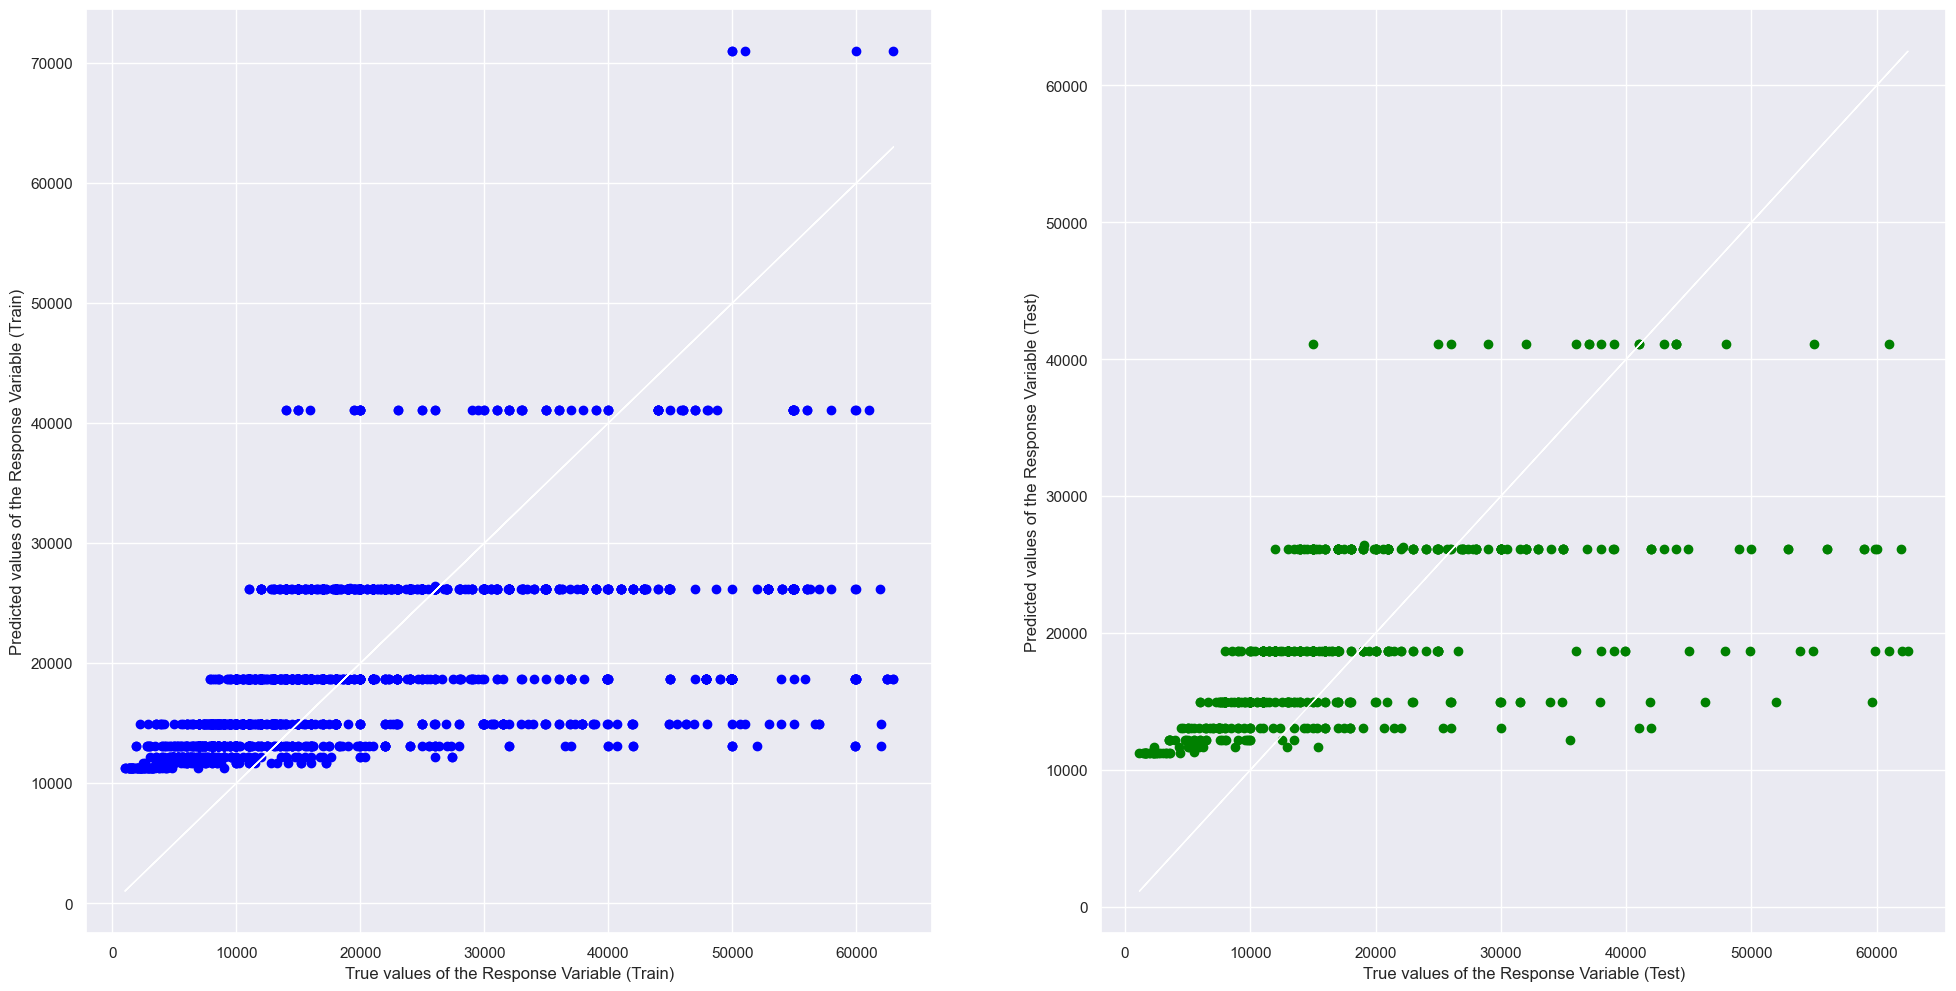

In [73]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(storage_test)
originalPrice_train_pred = linreg.predict(storage_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(storage_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 2621.1066338236883
Intercept of Regression: 8921.219848924575


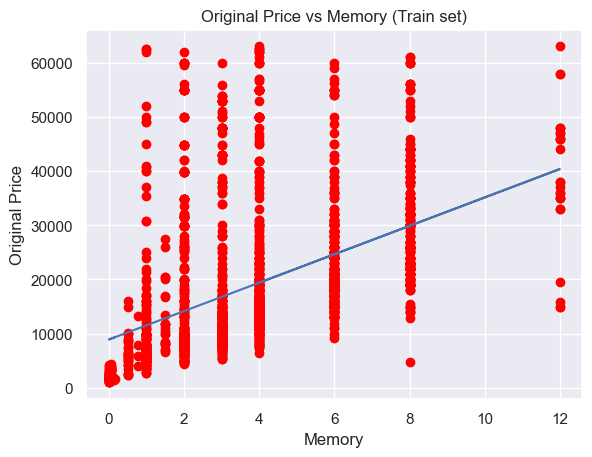

In [74]:
#Linear  Regression
memory = filtered_data[['Memory']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
memory_train, memory_test, originalPrice_train, originalPrice_test = train_test_split(memory, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(memory_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(memory_train, originalPrice_train, color='red')
plt.plot(memory_train, linreg.predict(memory_train))
plt.title("Original Price vs Memory (Train set)")
plt.xlabel('Memory')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.2079437302912559
Mean Squared Error (MSE): 141316517.97318456

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.2601617343256549
Mean Squared Error (MSE): 120809601.21321931


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

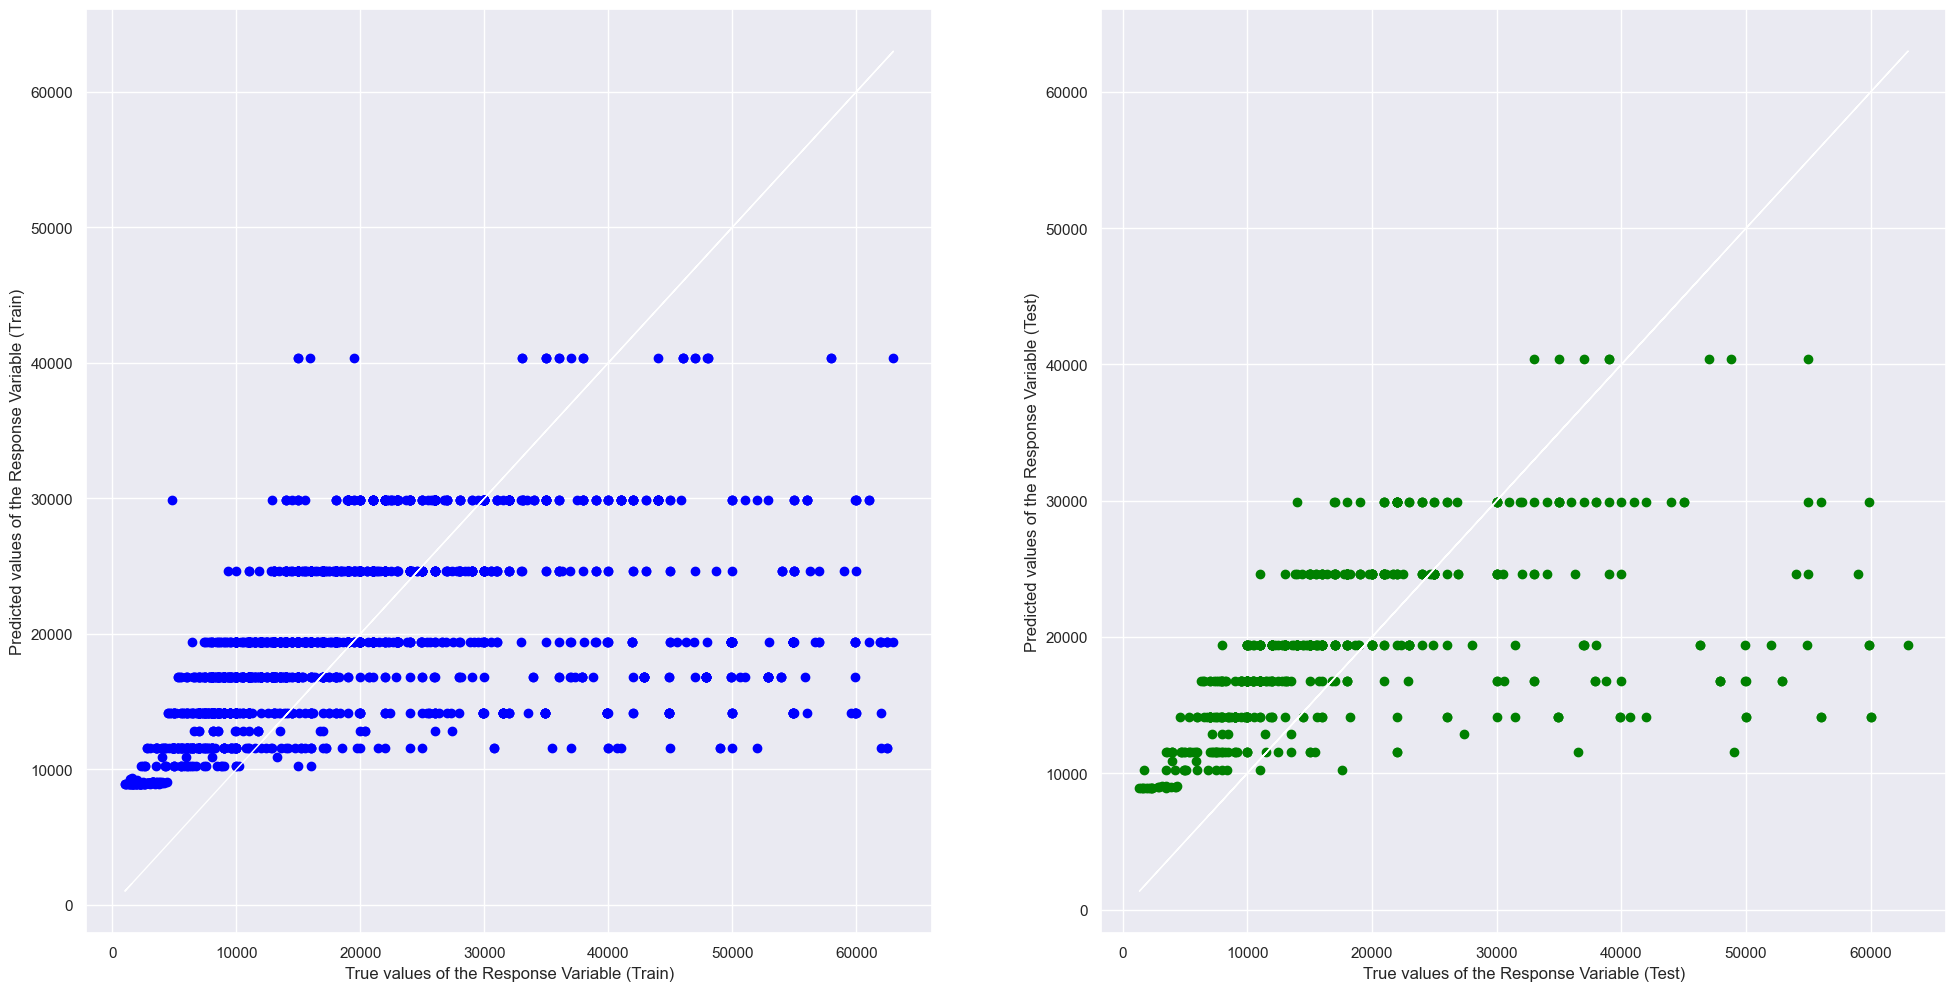

In [75]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(memory_test)
originalPrice_train_pred = linreg.predict(memory_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(memory_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Coefficients of Regression: 21135.894331398336
Intercept of Regression: -69827.11206130826


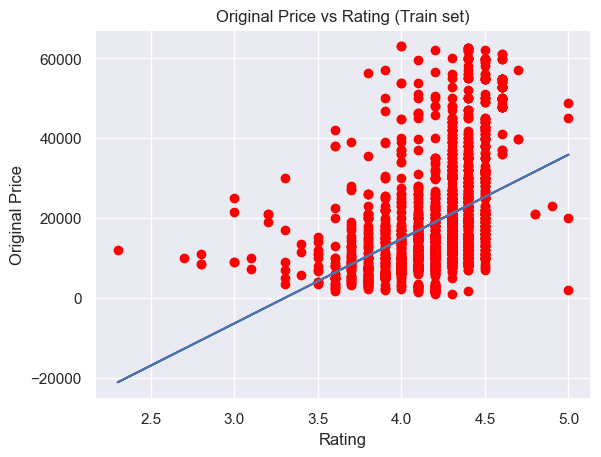

In [76]:
#Linear  Regression
rating = filtered_data[['Rating']] #Predictor
originalPrice = filtered_data['Original Price'] #Response

#Split the dataset into training and test set (80:20)
rating_train, rating_test, originalPrice_train, originalPrice_test = train_test_split(rating, originalPrice, test_size = 0.2)


#Fit linear regression into the training set
linreg = LinearRegression()
linreg.fit(rating_train, originalPrice_train)
print("Coefficients of Regression: {}".format(linreg.coef_[0])) 
print("Intercept of Regression: {}".format(linreg.intercept_)) 

#Plot the regression line
plt.scatter(rating_train, originalPrice_train, color='red')
plt.plot(rating_train, linreg.predict(rating_train))
plt.title("Original Price vs Rating (Train set)")
plt.xlabel('Rating')
plt.ylabel('Original Price')
plt.show()

Goodness of Fit of the Model Train Dataset
Explained Variance (R^2): 0.17460818993916516
Mean Squared Error (MSE): 144107644.59140944

Goodness of Fit of the Model Test Dataset
Explained Variance (R^2): 0.17311186560569602
Mean Squared Error (MSE): 148014129.87260973


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

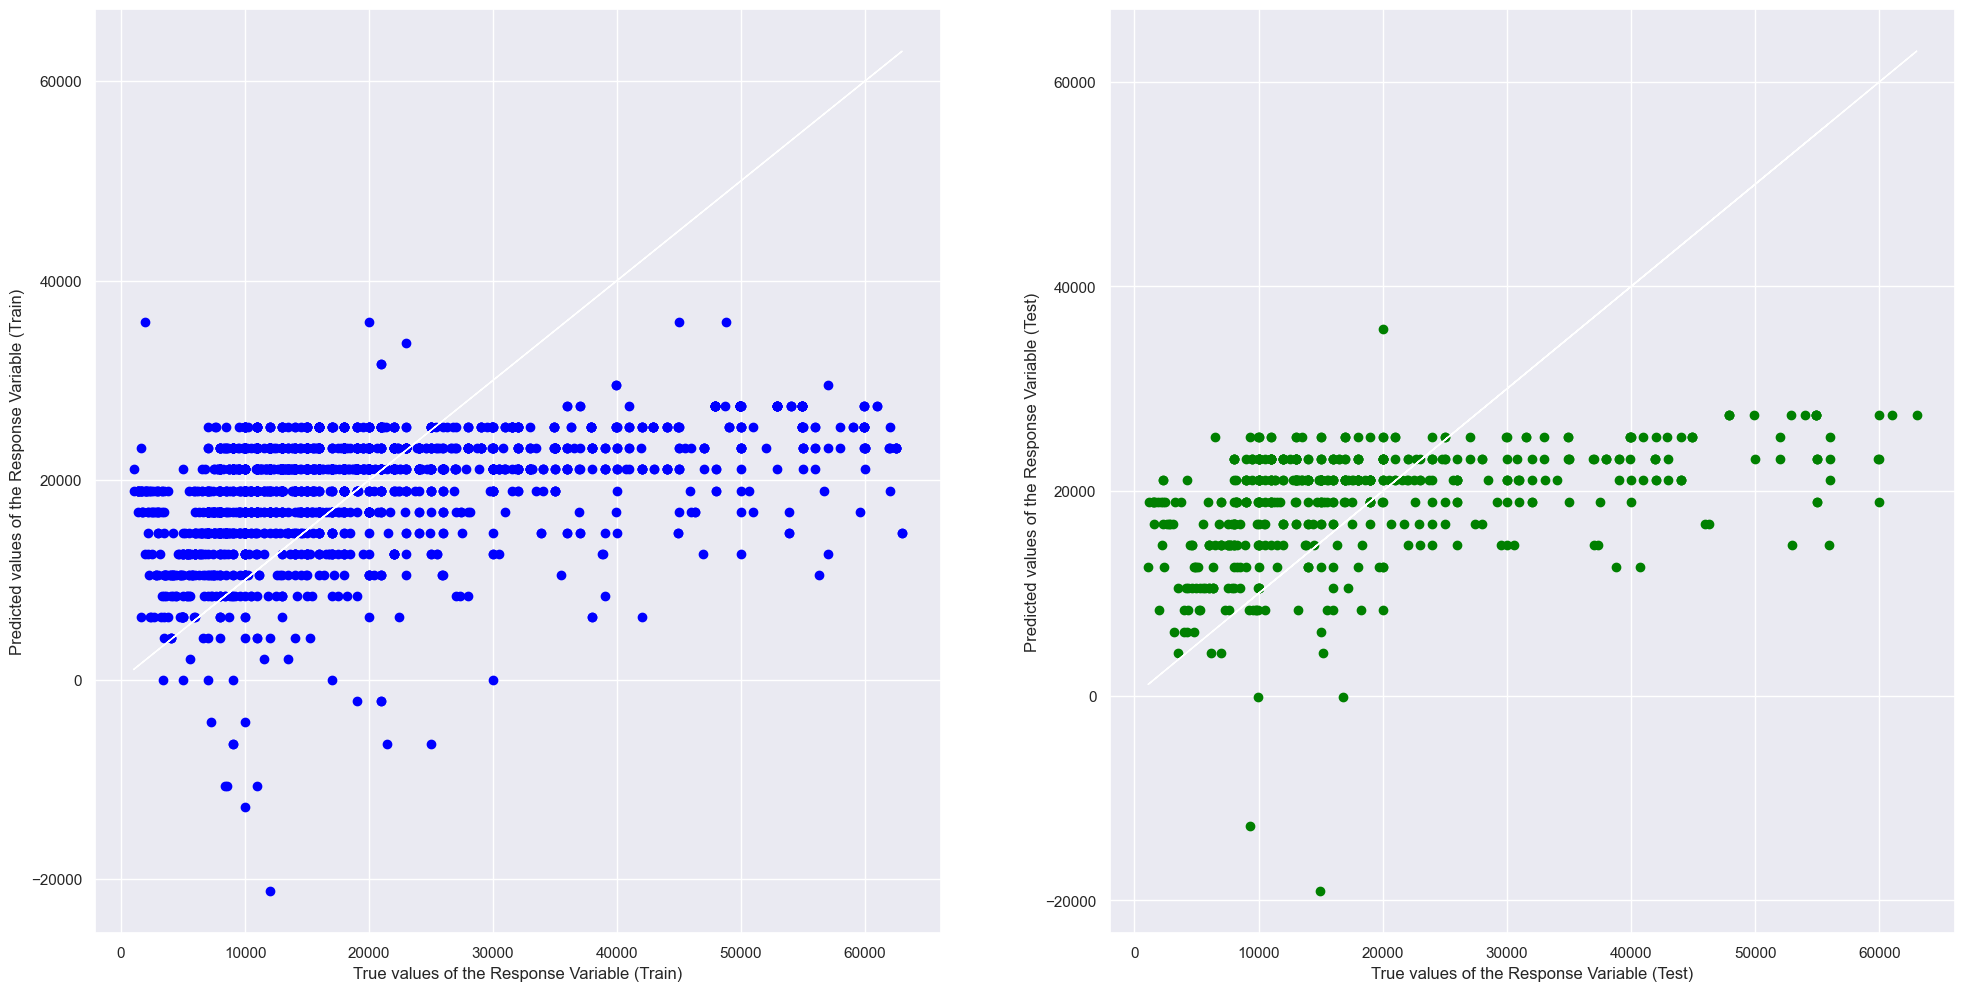

In [77]:
#Goodness of Fit of the model for the train set
originalPrice_test_pred = linreg.predict(rating_test)
originalPrice_train_pred = linreg.predict(rating_train)


#Goodness of Fit (on Train data)
print("Goodness of Fit of the Model Train Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_train, originalPrice_train)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_train, originalPrice_train_pred)))
print()

#Goodness of Fit (on Test Data)
print("Goodness of Fit of the Model Test Dataset")
print("Explained Variance (R^2): {}".format(linreg.score(rating_test, originalPrice_test)))
print("Mean Squared Error (MSE): {}".format(mean_squared_error(originalPrice_test, originalPrice_test_pred)))


#Plot the predictions vs the true values
f, axes = plt.subplots(1,2, figsize=(24,12))
axes[0].scatter(originalPrice_train, originalPrice_train_pred, color='blue')
axes[0].plot(originalPrice_train, originalPrice_train, 'w-', linewidth=1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")


axes[1].scatter(originalPrice_test, originalPrice_test_pred, color='green')
axes[1].plot(originalPrice_test, originalPrice_test, 'w-', linewidth=1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

Now, lets investigate whether there is perhaps a mutual relationship between brand and original price 

<Axes: xlabel='Original Price', ylabel='Brands'>

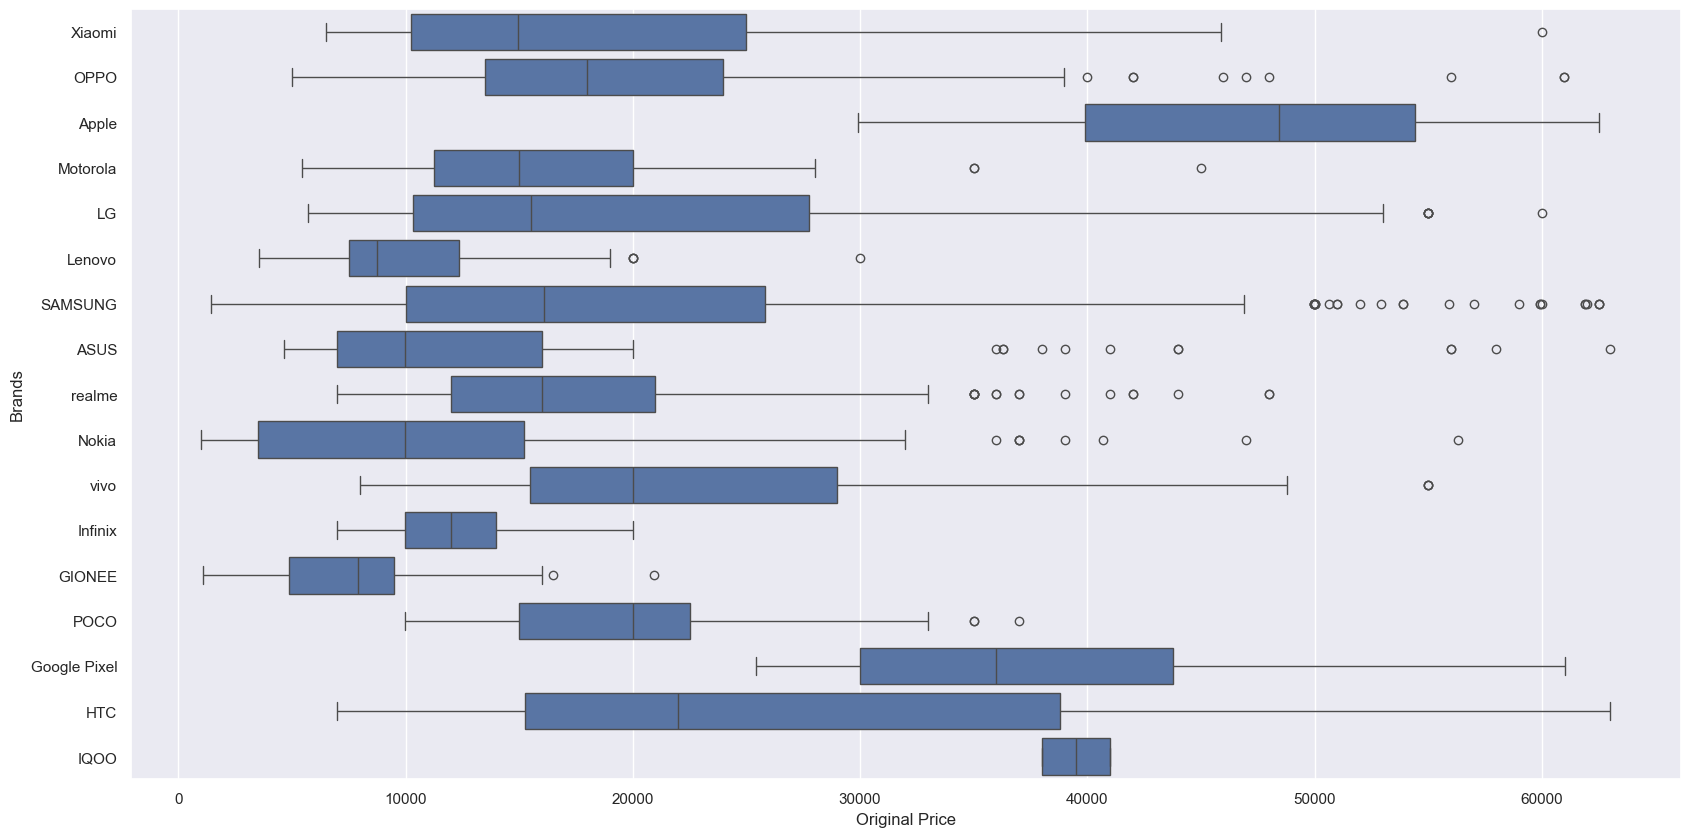

In [78]:
originalPrice = pd.DataFrame(filtered_data['Original Price'])
brands = pd.DataFrame(filtered_data['Brands'])

originalPrice_train, originalPrice_test, brands_train, brands_test = train_test_split(originalPrice, brands, test_size = 0.2)

joint = pd.concat([originalPrice_train, brands_train], axis=1).reindex(originalPrice_train.index)

f = plt.figure(figsize=(20,10))
sb.boxplot(x="Original Price", y="Brands", data = joint, orient="h")

In [79]:
#Function to split datapoints into 2 categories 

bins = [0, 30000, 70000]
labels = ["<= 30000", ">30000"]

filtered_data["Original Price"] = pd.cut(filtered_data["Original Price"], bins=bins, labels=labels)
filtered_data.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8.000,128.000,Yes,4.3,19330,<= 30000,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2.000,16.000,Yes,3.8,10199,<= 30000,Nokia 3.2,0,0.000000
3,Infinix,Note 5,Ice Blue,4.000,64.000,Yes,4.2,12999,<= 30000,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4.000,64.000,Yes,4.6,49900,>30000,Apple iPhone 11,0,0.000000
5,GIONEE,L800,Black,0.008,0.016,Yes,4.0,2199,<= 30000,GIONEE L800,0,0.000000


# Create a Classification Model

Let's start by encoding the levels of our categorical predictor variable ("Brands") as integers. We will do so by encoding the unordered categorical variable by integers. This method is OneHotEncoding from the sklearn preprocessing module.

In [80]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
predictor_variable_cat = filtered_data[['Brands']]
ohe.fit(predictor_variable_cat)
predictor_variable_cat_ohe = pd.DataFrame(ohe.transform(predictor_variable_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(predictor_variable_cat.columns))

# Check the encoded variables 
predictor_variable_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brands_ASUS          2625 non-null   float64
 1   Brands_Apple         2625 non-null   float64
 2   Brands_GIONEE        2625 non-null   float64
 3   Brands_Google Pixel  2625 non-null   float64
 4   Brands_HTC           2625 non-null   float64
 5   Brands_IQOO          2625 non-null   float64
 6   Brands_Infinix       2625 non-null   float64
 7   Brands_LG            2625 non-null   float64
 8   Brands_Lenovo        2625 non-null   float64
 9   Brands_Motorola      2625 non-null   float64
 10  Brands_Nokia         2625 non-null   float64
 11  Brands_OPPO          2625 non-null   float64
 12  Brands_POCO          2625 non-null   float64
 13  Brands_SAMSUNG       2625 non-null   float64
 14  Brands_Xiaomi        2625 non-null   float64
 15  Brands_realme        2625 non-null   f

In [81]:
# Combining Numeric features with the OHE Categorical features
filtered_data_num = filtered_data[['Memory','Storage','Rating']]
filtered_data_response = filtered_data['Original Price']

filtered_data_ohe = pd.concat([filtered_data_num, filtered_data_response ,predictor_variable_cat_ohe], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

# Check the final dataframe
filtered_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2625 entries, 0 to 3113
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Memory               2625 non-null   float64 
 1   Storage              2625 non-null   float64 
 2   Rating               2625 non-null   float64 
 3   Original Price       2625 non-null   category
 4   Brands_ASUS          2212 non-null   float64 
 5   Brands_Apple         2212 non-null   float64 
 6   Brands_GIONEE        2212 non-null   float64 
 7   Brands_Google Pixel  2212 non-null   float64 
 8   Brands_HTC           2212 non-null   float64 
 9   Brands_IQOO          2212 non-null   float64 
 10  Brands_Infinix       2212 non-null   float64 
 11  Brands_LG            2212 non-null   float64 
 12  Brands_Lenovo        2212 non-null   float64 
 13  Brands_Motorola      2212 non-null   float64 
 14  Brands_Nokia         2212 non-null   float64 
 15  Brands_OPPO          2212 

### Create and Fit the Model

Now, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

[Text(0.5446428571428571, 0.9, 'Rating <= 4.45\ngini = 0.282\nsamples = 2100\nvalue = [1743, 357]\nclass = <=30000'),
 Text(0.2857142857142857, 0.7, 'Memory <= 7.0\ngini = 0.204\nsamples = 1820\nvalue = [1610, 210]\nclass = <=30000'),
 Text(0.14285714285714285, 0.5, 'Storage <= 24.0\ngini = 0.134\nsamples = 1615\nvalue = [1498, 117]\nclass = <=30000'),
 Text(0.07142857142857142, 0.3, 'Rating <= 4.35\ngini = 0.034\nsamples = 467\nvalue = [459, 8]\nclass = <=30000'),
 Text(0.03571428571428571, 0.1, 'gini = 0.009\nsamples = 450\nvalue = [448, 2]\nclass = <=30000'),
 Text(0.10714285714285714, 0.1, 'gini = 0.457\nsamples = 17\nvalue = [11, 6]\nclass = <=30000'),
 Text(0.21428571428571427, 0.3, 'Memory <= 1.5\ngini = 0.172\nsamples = 1148\nvalue = [1039, 109]\nclass = <=30000'),
 Text(0.17857142857142858, 0.1, 'gini = 0.49\nsamples = 14\nvalue = [6, 8]\nclass = >30000'),
 Text(0.25, 0.1, 'gini = 0.162\nsamples = 1134\nvalue = [1033, 101]\nclass = <=30000'),
 Text(0.42857142857142855, 0.5, 'S

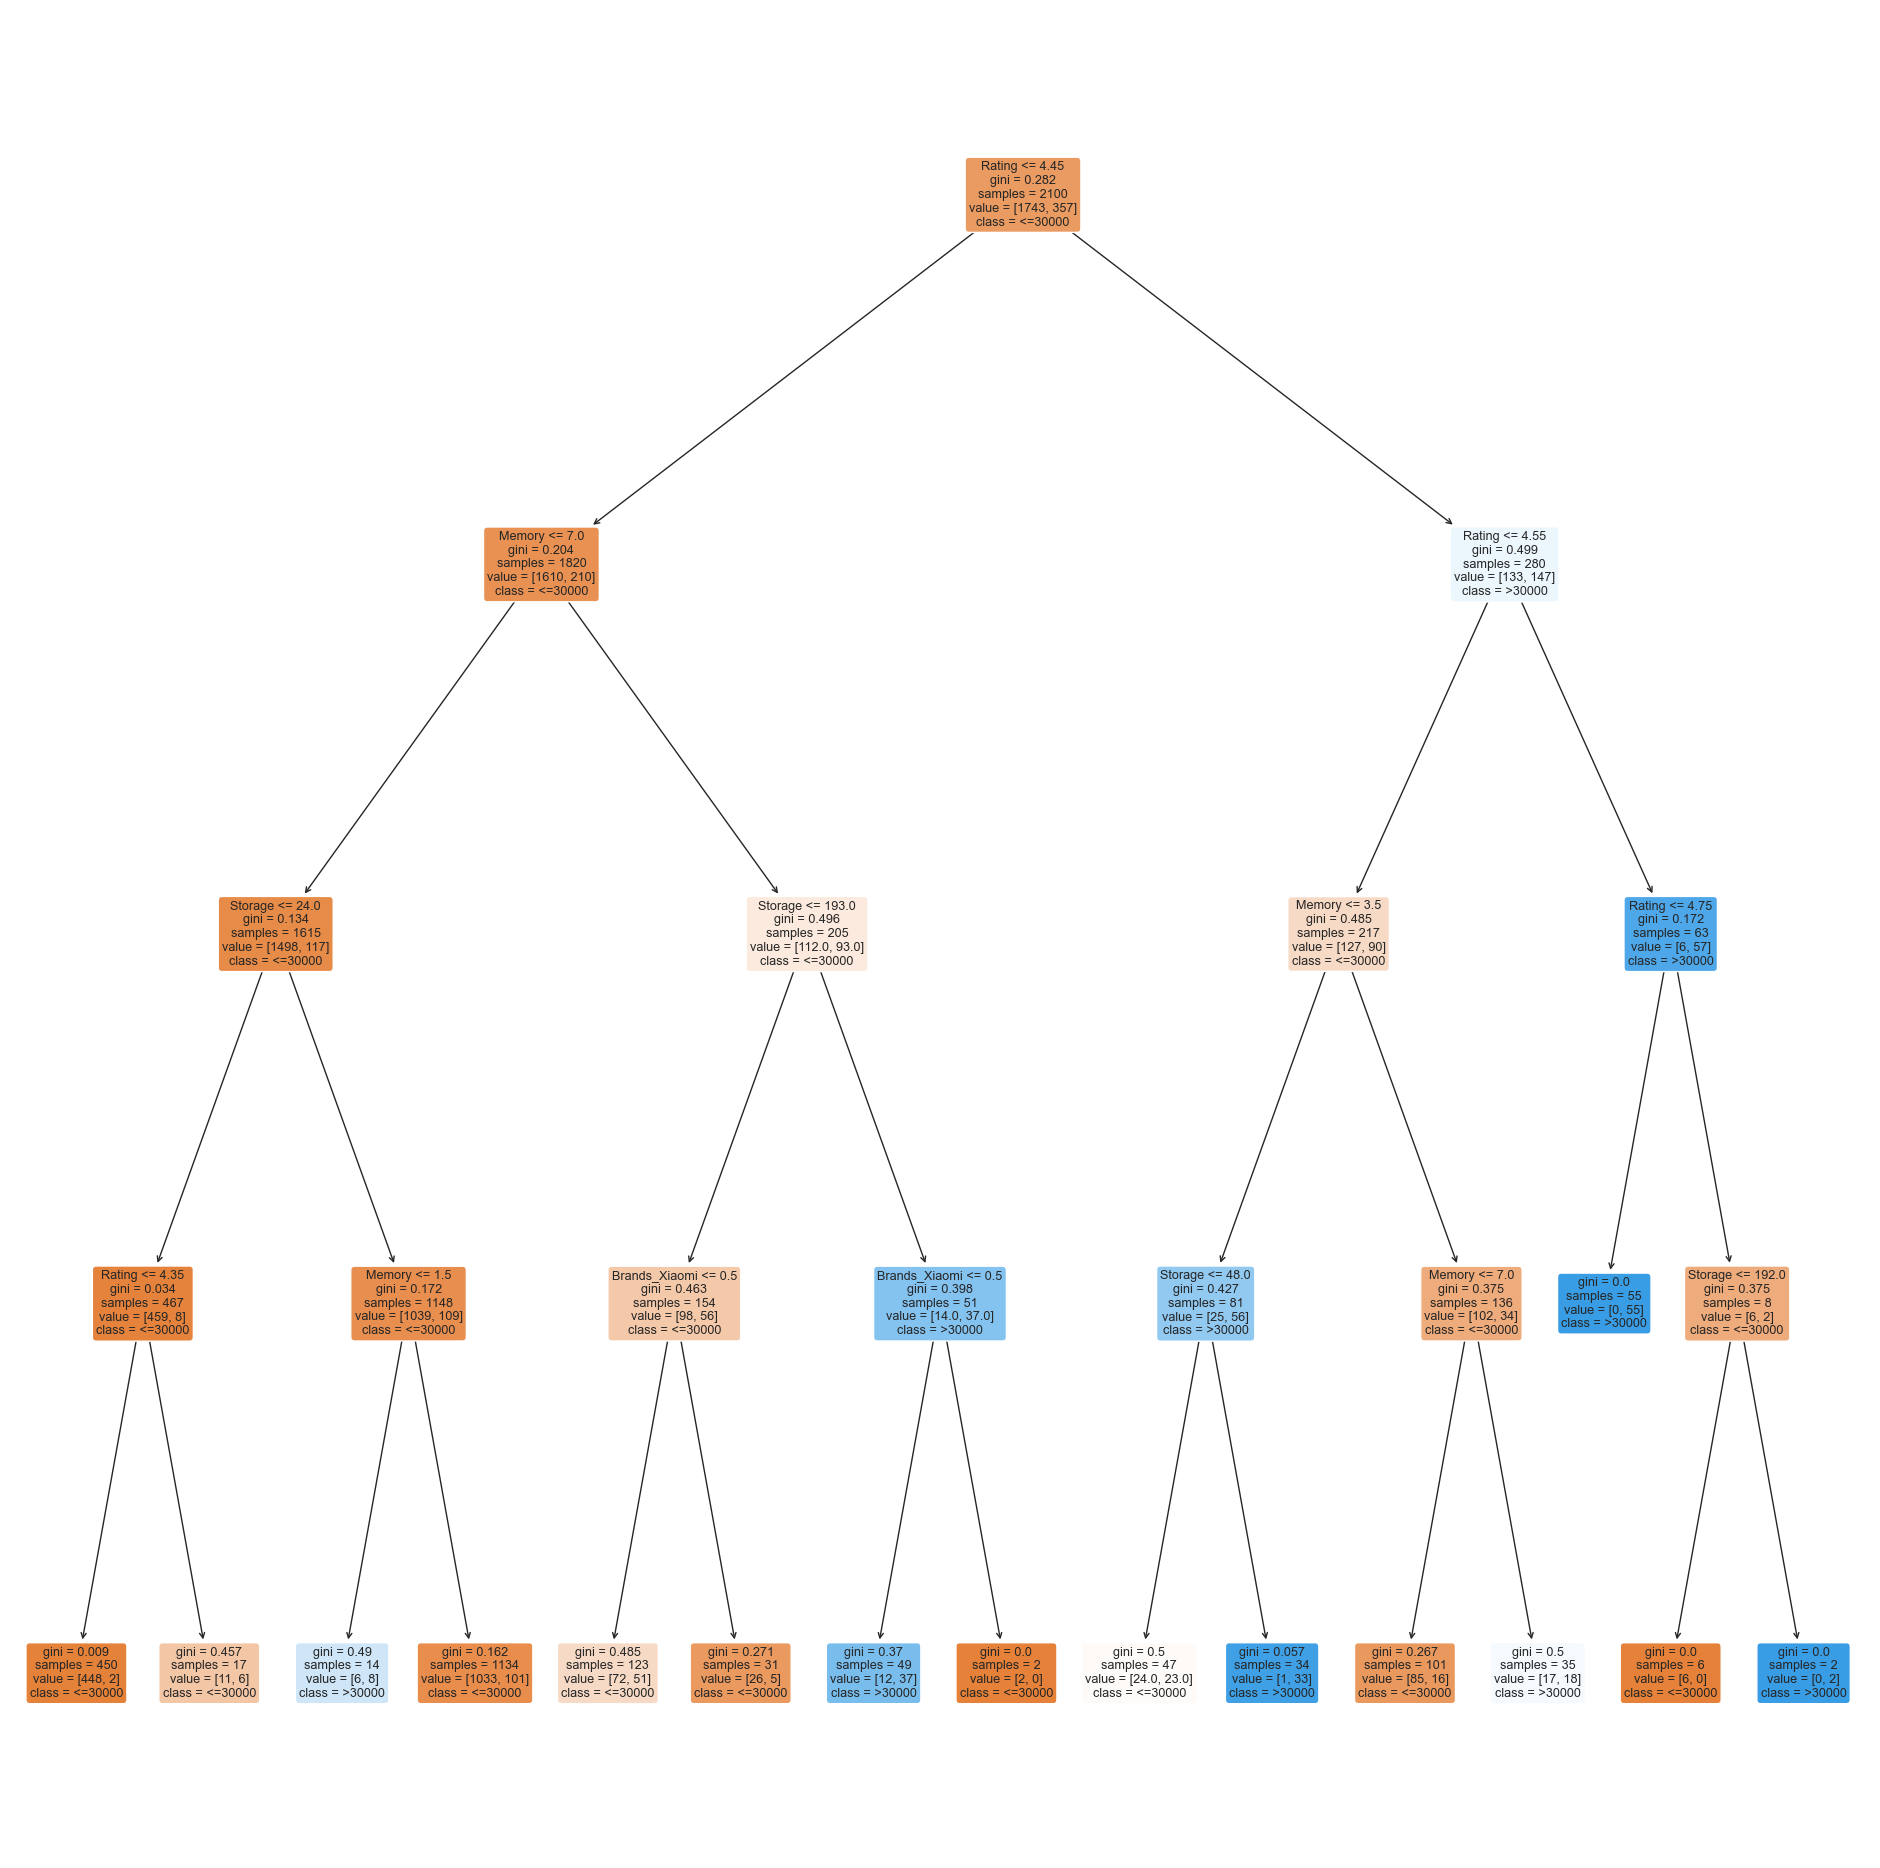

In [82]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(filtered_data_ohe['Original Price'])
X = pd.DataFrame(filtered_data_ohe.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["<=30000",">30000"])

Train Data
Accuracy  :	 0.8857142857142857

TPR Train :	 0.42857142857142855
TNR Train :	 0.9793459552495697

FPR Train :	 0.020654044750430294
FNR Train :	 0.5714285714285714


<Axes: >

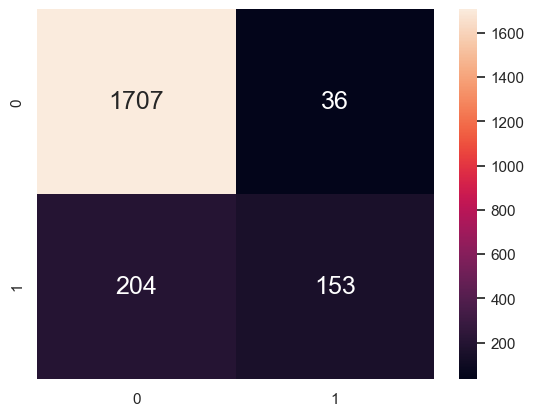

In [83]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Refining the Model

Let's refine the previous model by balancing the classes of the response `Original Price` in the training data. Keeping the OneHotEncoding same as before.

In [84]:
# Upsample >30000 to match <=30000
from sklearn.utils import resample

data_high_price = filtered_data_ohe[filtered_data_ohe["Original Price"] == ">30000"]
data_low_price = filtered_data_ohe[filtered_data_ohe["Original Price"] == "<= 30000"]
 
# Upsample the Bad samples
data_high_price_up = resample(data_high_price, 
                        replace=True,                         # sample with replacement
                        n_samples=data_low_price.shape[0])    # to match number of samples <=30000
 
# Combine the two classes back after upsampling
data_ohe_up = pd.concat([data_high_price_up, data_low_price])
 
# Check the ratio of the classes
data_ohe_up['Original Price'].value_counts()

Original Price
<= 30000    2181
>30000      2181
Name: count, dtype: int64

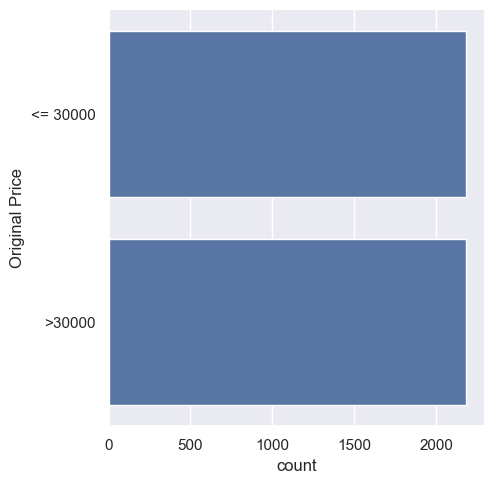

In [85]:
# Quick plot to check the balanced classes visually
sb.catplot(y = 'Original Price', data = data_ohe_up, kind = "count")

In [86]:
# Confirm that the OHE is still in place
# and that the samples have now increased
data_ohe_up.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4362 entries, 991 to 3113
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Memory               4362 non-null   float64 
 1   Storage              4362 non-null   float64 
 2   Rating               4362 non-null   float64 
 3   Original Price       4362 non-null   category
 4   Brands_ASUS          3691 non-null   float64 
 5   Brands_Apple         3691 non-null   float64 
 6   Brands_GIONEE        3691 non-null   float64 
 7   Brands_Google Pixel  3691 non-null   float64 
 8   Brands_HTC           3691 non-null   float64 
 9   Brands_IQOO          3691 non-null   float64 
 10  Brands_Infinix       3691 non-null   float64 
 11  Brands_LG            3691 non-null   float64 
 12  Brands_Lenovo        3691 non-null   float64 
 13  Brands_Motorola      3691 non-null   float64 
 14  Brands_Nokia         3691 non-null   float64 
 15  Brands_OPPO          369

[Text(0.5, 0.9, 'Rating <= 4.35\ngini = 0.5\nsamples = 3489\nvalue = [1739.0, 1750.0]\nclass = >30000'),
 Text(0.25, 0.7, 'Memory <= 7.0\ngini = 0.427\nsamples = 1898\nvalue = [1312, 586]\nclass = <=30000'),
 Text(0.125, 0.5, 'Storage <= 24.0\ngini = 0.323\nsamples = 1553\nvalue = [1239, 314]\nclass = <=30000'),
 Text(0.0625, 0.3, 'Brands_Apple <= 0.5\ngini = 0.054\nsamples = 468\nvalue = [455, 13]\nclass = <=30000'),
 Text(0.03125, 0.1, 'gini = 0.023\nsamples = 431\nvalue = [426, 5]\nclass = <=30000'),
 Text(0.09375, 0.1, 'gini = 0.339\nsamples = 37\nvalue = [29, 8]\nclass = <=30000'),
 Text(0.1875, 0.3, 'Memory <= 5.0\ngini = 0.401\nsamples = 1085\nvalue = [784, 301]\nclass = <=30000'),
 Text(0.15625, 0.1, 'gini = 0.352\nsamples = 769\nvalue = [594, 175]\nclass = <=30000'),
 Text(0.21875, 0.1, 'gini = 0.479\nsamples = 316\nvalue = [190, 126]\nclass = <=30000'),
 Text(0.375, 0.5, 'Brands_Xiaomi <= 0.5\ngini = 0.334\nsamples = 345\nvalue = [73, 272]\nclass = >30000'),
 Text(0.3125, 0.3

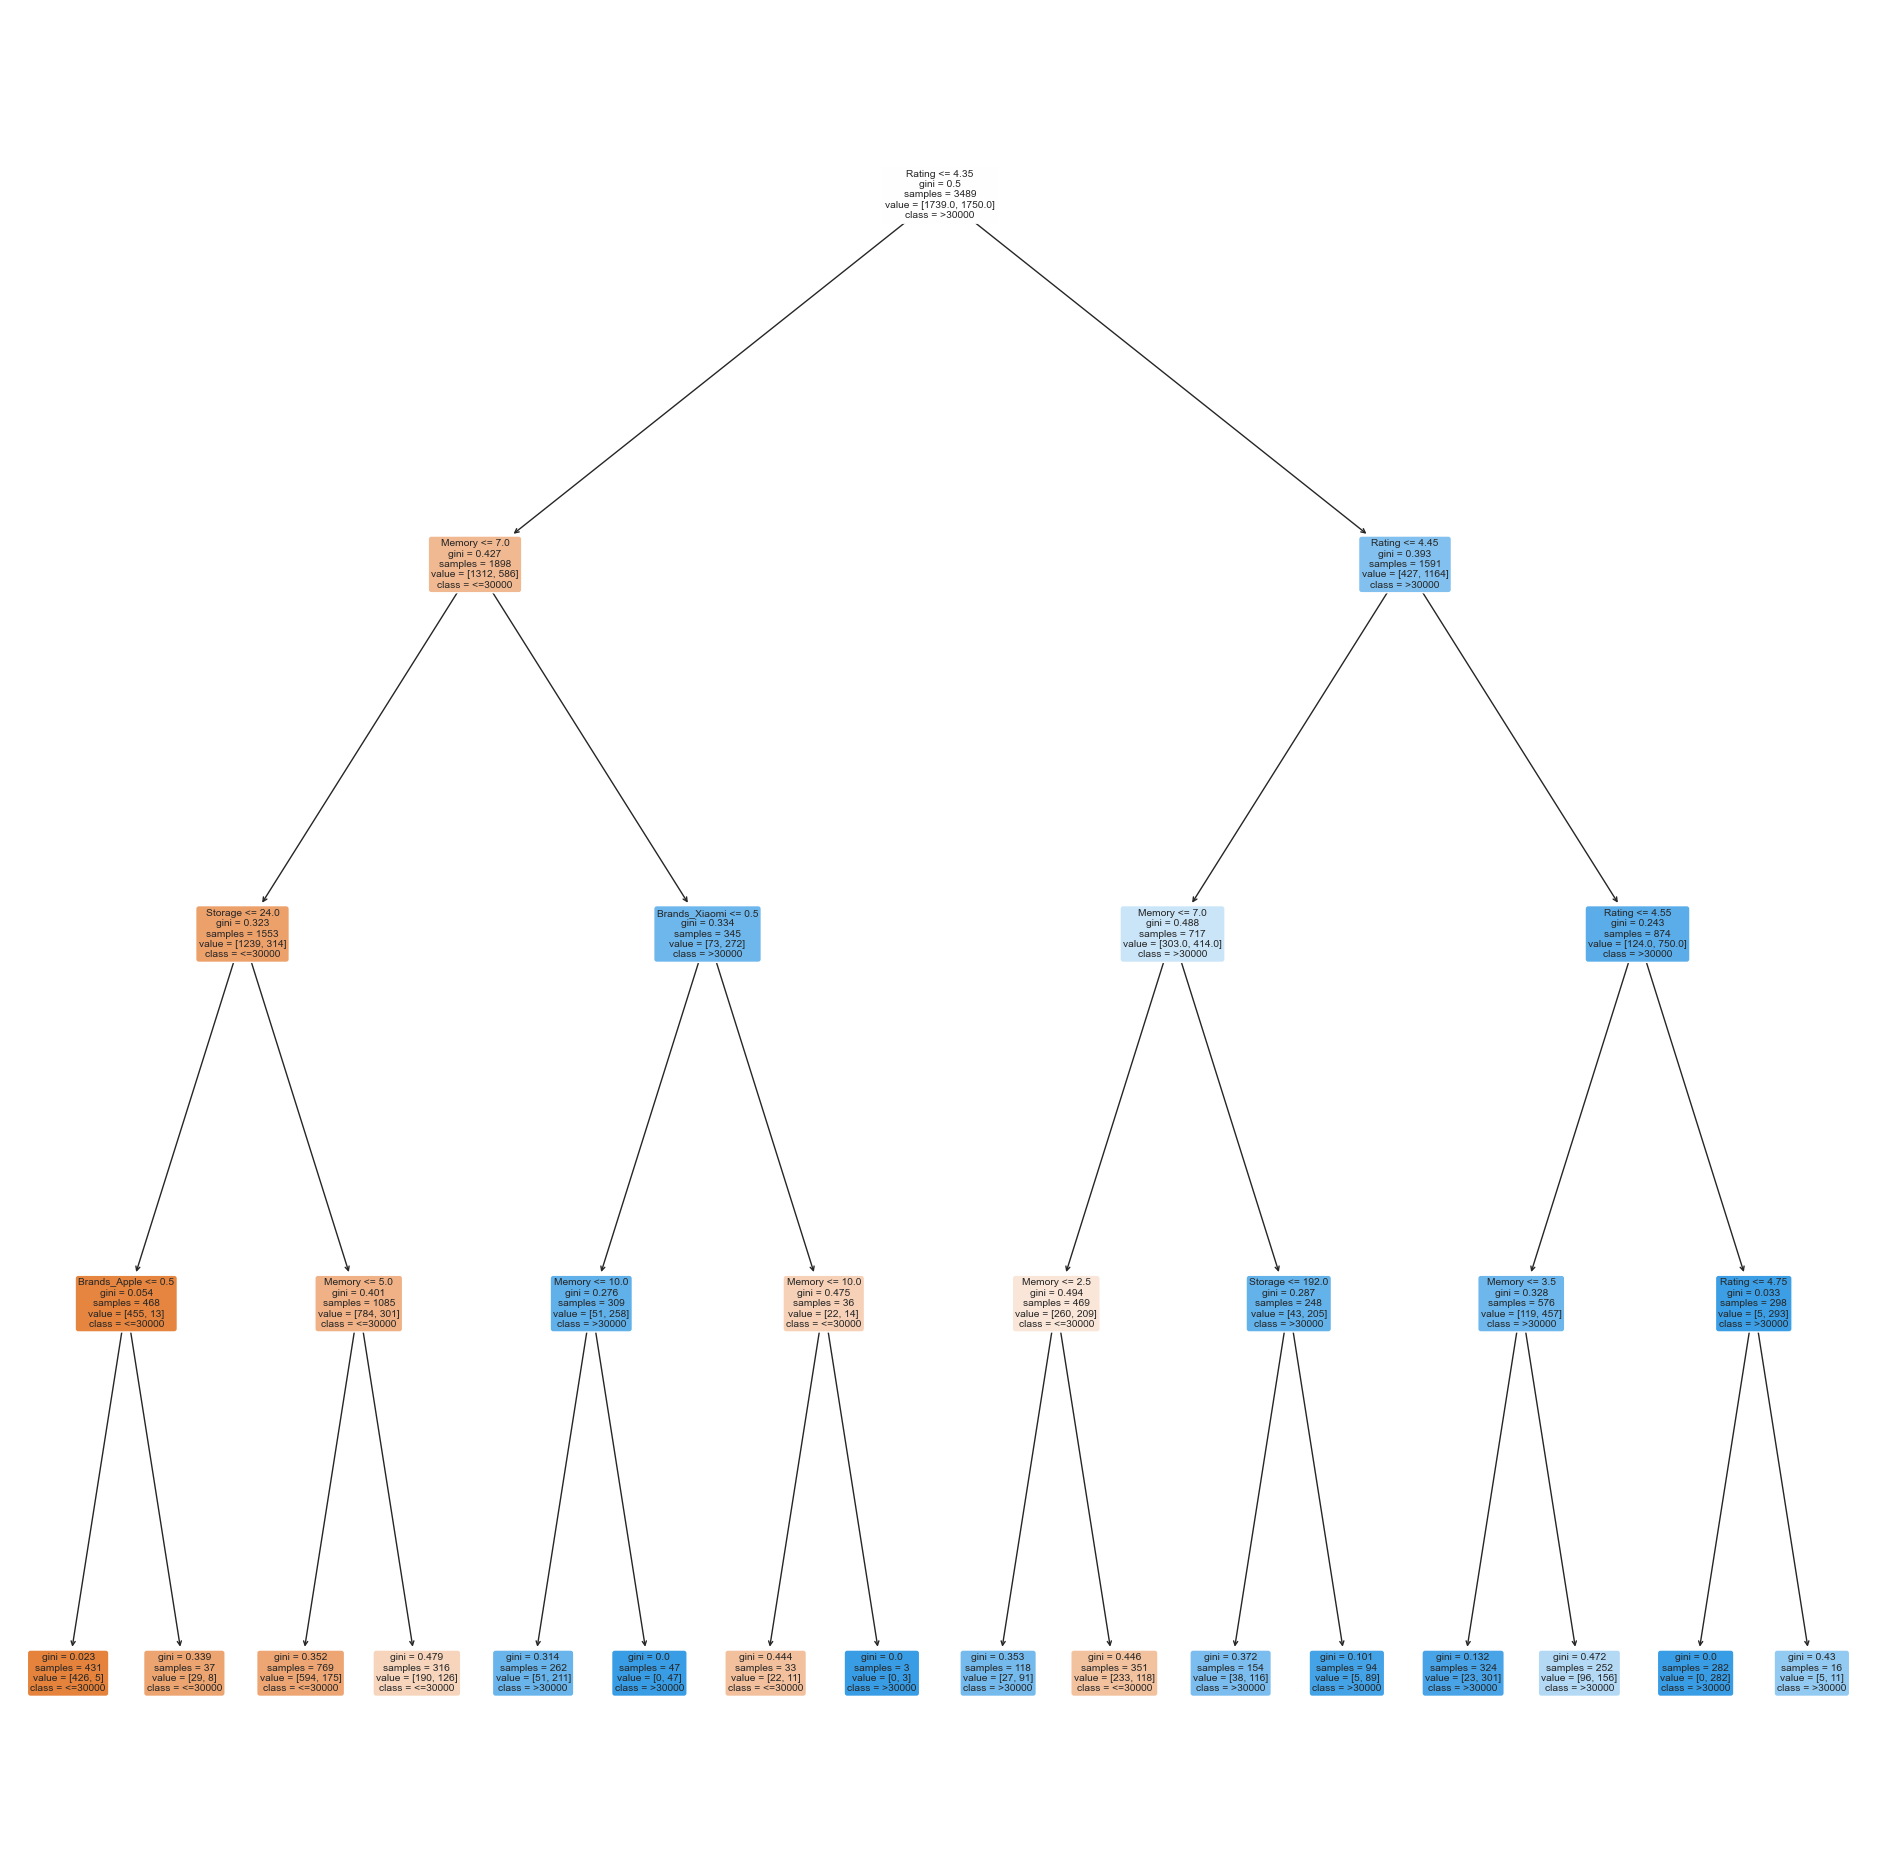

In [87]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["<=30000",">30000"])

Train Data
Accuracy  :	 0.8028088277443394

TPR Train :	 0.7468571428571429
TNR Train :	 0.8591144335825187

FPR Train :	 0.14088556641748132
FNR Train :	 0.25314285714285717


<Axes: >

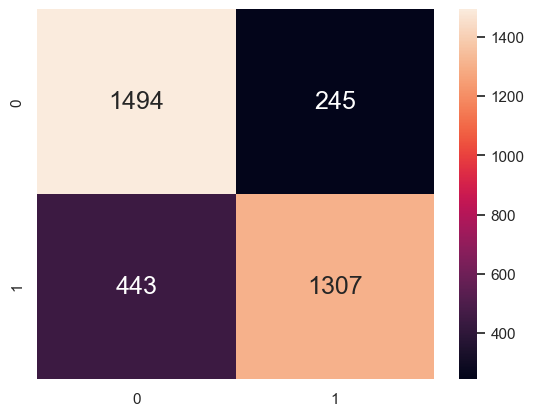

In [88]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7846506300114547

TPR Test :	 0.7146171693735499
TNR Test :	 0.8529411764705882

FPR Test :	 0.14705882352941177
FNR Test :	 0.2853828306264501


<Axes: >

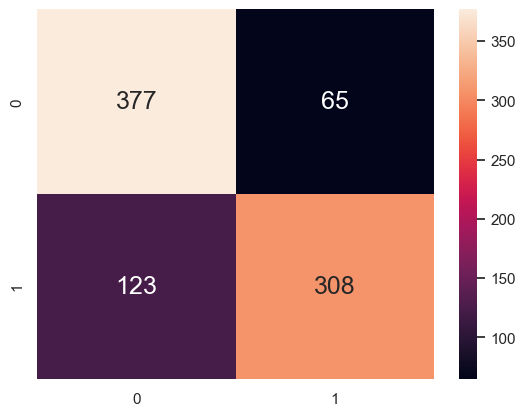

In [89]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

# Further refinement of Prediction Model

Using an ensemble of trees for better classification, tree based classifier -- `RandomForest`

In [90]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train['Original Price'].to_numpy())

RandomForestClassifier(max_depth=4)

Train Data
Accuracy  :	 0.7950702206936084

TPR Train :	 0.7315819531696174
TNR Train :	 0.8590333716915995

FPR Train :	 0.14096662830840045
FNR Train :	 0.2684180468303826


<Axes: >

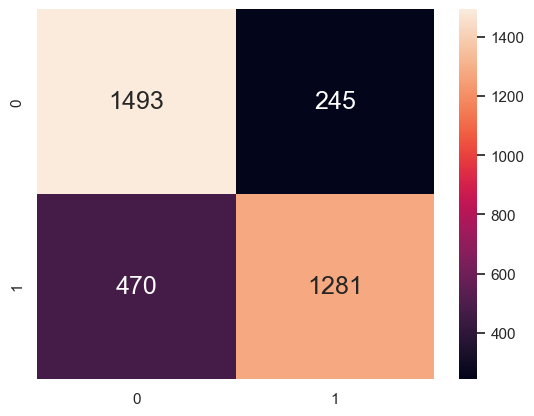

In [91]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8155784650630011

TPR Test :	 0.7767441860465116
TNR Test :	 0.8532731376975169

FPR Test :	 0.14672686230248308
FNR Test :	 0.22325581395348837


<Axes: >

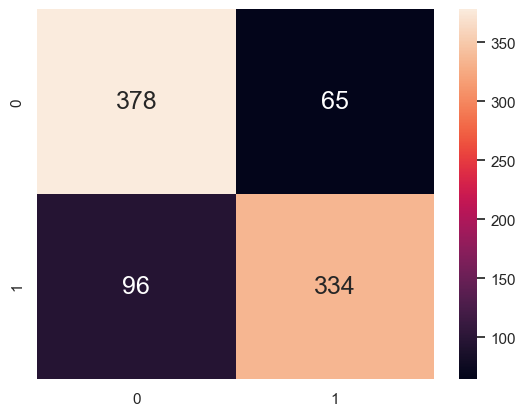

In [92]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Using GridSearch

In [93]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [94]:
# Import GridSearch for hyperparameter tuning using Cross-Validation (CV)
from sklearn.model_selection import GridSearchCV

# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train['Original Price'].to_numpy())
# hpGrid.fit(X_train, y_train['Original Price'].ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [95]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=1000)
0.8211557514193041


### Use the Best Model found through GridSearchCV

In [96]:
# Extract Response and Predictors
y = pd.DataFrame(data_ohe_up['Original Price'])
X = pd.DataFrame(data_ohe_up.drop('Original Price', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Import RandomForestClassifier model from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 200,   # found using GridSearchCV
                                 max_depth = 10)       # found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train["Original Price"].to_numpy())

RandomForestClassifier(max_depth=10, n_estimators=200)

Train Data
Accuracy  :	 0.8541129263399255

TPR Train :	 0.8341939185312679
TNR Train :	 0.8739977090492554

FPR Train :	 0.12600229095074456
FNR Train :	 0.16580608146873207


<Axes: >

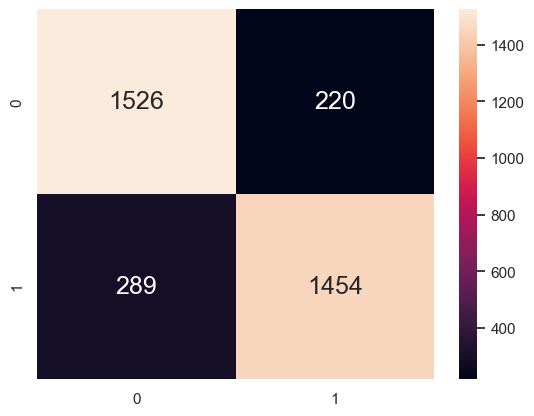

In [97]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8178694158075601

TPR Test :	 0.7831050228310502
TNR Test :	 0.8528735632183908

FPR Test :	 0.1471264367816092
FNR Test :	 0.21689497716894976


<Axes: >

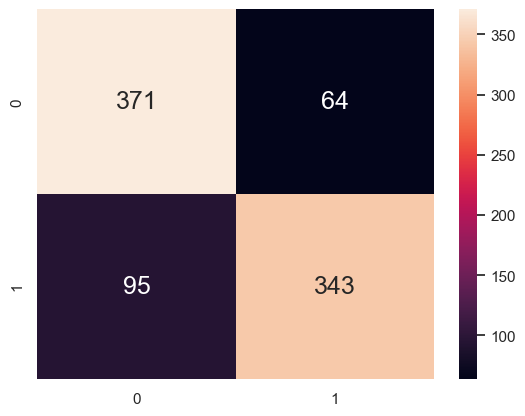

In [98]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

## Multi-Variate Linear Regression

We will start by setting up a Multi-Variate Linear Regression problem. 

Response Variable : **Original Price**     
Predictor Feature : **Memory, Storage, Rating, Brands**       

> Regression Model : Total = $a_1$ $\times$ Memory + $a_2$ $\times$ Storage + $a_3$ $\times$ Rating + $a_4$ $\times$ Brands + $b$  

Extract the variables and the associated data as a Pandas `DataFrame`.

In [99]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Ordinal Encoding of categorical predictors 
predictor_variable_cat = filtered_data['Brands']
le.fit(predictor_variable_cat)
predictor_variable_cat_le = pd.DataFrame(le.transform(predictor_variable_cat))

In [100]:
#Create a new dataframe
filtered_data_le = pd.concat([filtered_data_num, originalPrice ,predictor_variable_cat_le], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

print(filtered_data_le)

      Memory  Storage  Rating  Original Price     0
0      8.000  128.000     4.3         20999.0  13.0
1      2.000   16.000     3.8         10199.0  10.0
3      4.000   64.000     4.2         12999.0   1.0
4      4.000   64.000     4.6         49900.0   2.0
5      0.008    0.016     4.0          2199.0   1.0
...      ...      ...     ...             ...   ...
3107   0.512    4.000     4.0          5999.0   NaN
3108   0.004    0.002     4.2          2299.0   NaN
3109   6.000  128.000     4.4         19999.0   NaN
3111   2.000  128.000     4.5         44900.0   NaN
3113   3.000   32.000     4.2          7900.0   NaN

[2625 rows x 5 columns]


In [101]:
# Extract Response and Predictors
y = pd.DataFrame(filtered_data_le['Original Price'])
X = pd.DataFrame(filtered_data_le.drop('Original Price', axis = 1))

# Convert all column names to string
X.columns = X.columns.astype(str)

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (2100, 1) (2100, 4)
Test Set  : (525, 1) (525, 4)


<Axes: >

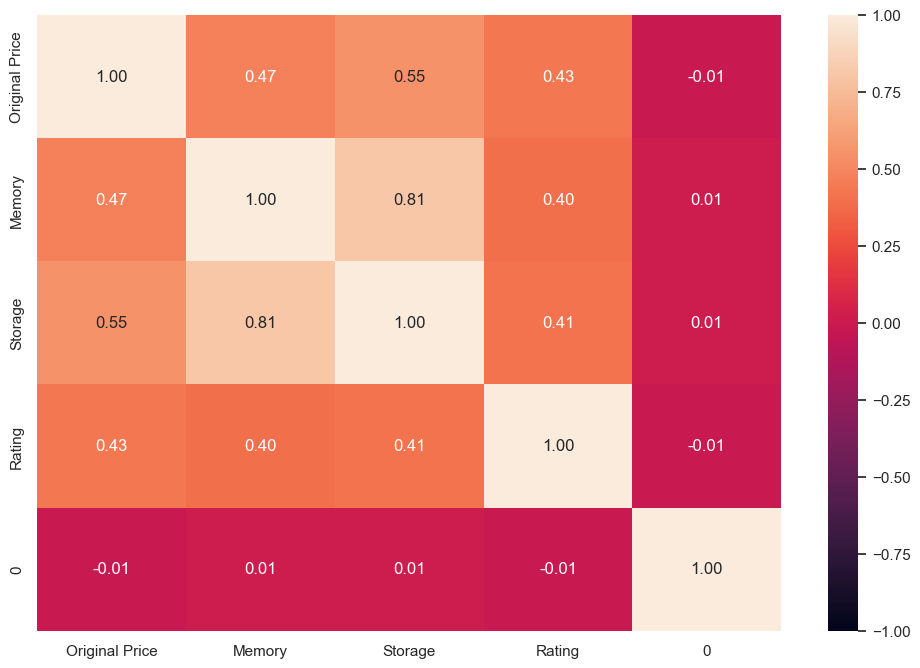

In [102]:
# Correlation between Response and the Predictors

# Convert all column names to string
X.columns = X.columns.astype(str)

trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [103]:
#Create a new dataframe
filtered_data_te = pd.concat([filtered_data_num, originalPrice ,brands], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)
print(filtered_data_te)

import numpy as np
from sklearn.preprocessing import TargetEncoder
filtered_data_te = filtered_data_te.dropna()
y = pd.DataFrame(filtered_data_te['Original Price'])

X = pd.DataFrame(filtered_data_te.drop('Original Price', axis = 1))

enc_auto = TargetEncoder(smooth="auto")

X_transform = enc_auto.fit_transform(X, y)

# A high `smooth` parameter puts more weight on global mean on the categorical
# encodings:
enc_high_smooth = TargetEncoder(target_type="continuous", smooth=5000.0).fit_transform(X, y)
# X_high_smooth = enc_high_smooth.fit_transform(X, y)
# enc_high_smooth.target_mean_ 
# enc_high_smooth.encodings_

 # On the other hand, a low `smooth` parameter puts more weight on target
 # conditioned on the value of the categorical:
enc_low_smooth = TargetEncoder(target_type="continuous",smooth=1.0).fit_transform(X, y)
# enc_low_smooth.encodings_

      Memory  Storage  Rating  Original Price   Brands
0      8.000  128.000     4.3           20999  SAMSUNG
1      2.000   16.000     3.8           10199    Nokia
3      4.000   64.000     4.2           12999  Infinix
4      4.000   64.000     4.6           49900    Apple
5      0.008    0.016     4.0            2199   GIONEE
...      ...      ...     ...             ...      ...
3107   0.512    4.000     4.0            5999  SAMSUNG
3108   0.004    0.002     4.2            2299  SAMSUNG
3109   6.000  128.000     4.4           19999     POCO
3111   2.000  128.000     4.5           44900    Apple
3113   3.000   32.000     4.2            7900   GIONEE

[2625 rows x 5 columns]


/Users/wenjun/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/wenjun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wenjun/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [104]:
df_enc_low_smooth = pd.DataFrame(enc_low_smooth)

print(df_enc_low_smooth)

                 0             1             2             3
0     31081.402282  27114.053298  19473.532159  19369.159246
1     17437.694555  13306.328532  10545.978923  10851.060006
2     19612.212761  19896.130656  14896.589434  12195.939758
3     19509.186709  19786.248334  50762.151143  45607.826755
4      4901.559388   4951.702245  13924.966769   7962.871961
...            ...           ...           ...           ...
2620   7335.743459   7926.505986  14284.359577  19525.391107
2621   2303.916753   3145.570114  14896.589434  19624.623259
2622  22786.123580  27087.077957  22620.461596  19477.135293
2623  17363.838752  27114.053298  28405.511236  46110.189386
2624  16317.219948  15067.623129  14615.315201   8170.248128

[2625 rows x 4 columns]


In [105]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(enc_low_smooth, y, test_size = 0.2)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (2100, 1) (2100, 4)
Test Set  : (525, 1) (525, 4)


In [106]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)

# Print the Coefficients against Predictors
# pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [-16470.47770182]
Coefficients of Regression 	: a =  [[0.44390178 0.42194455 0.17942275 0.8052684 ]]


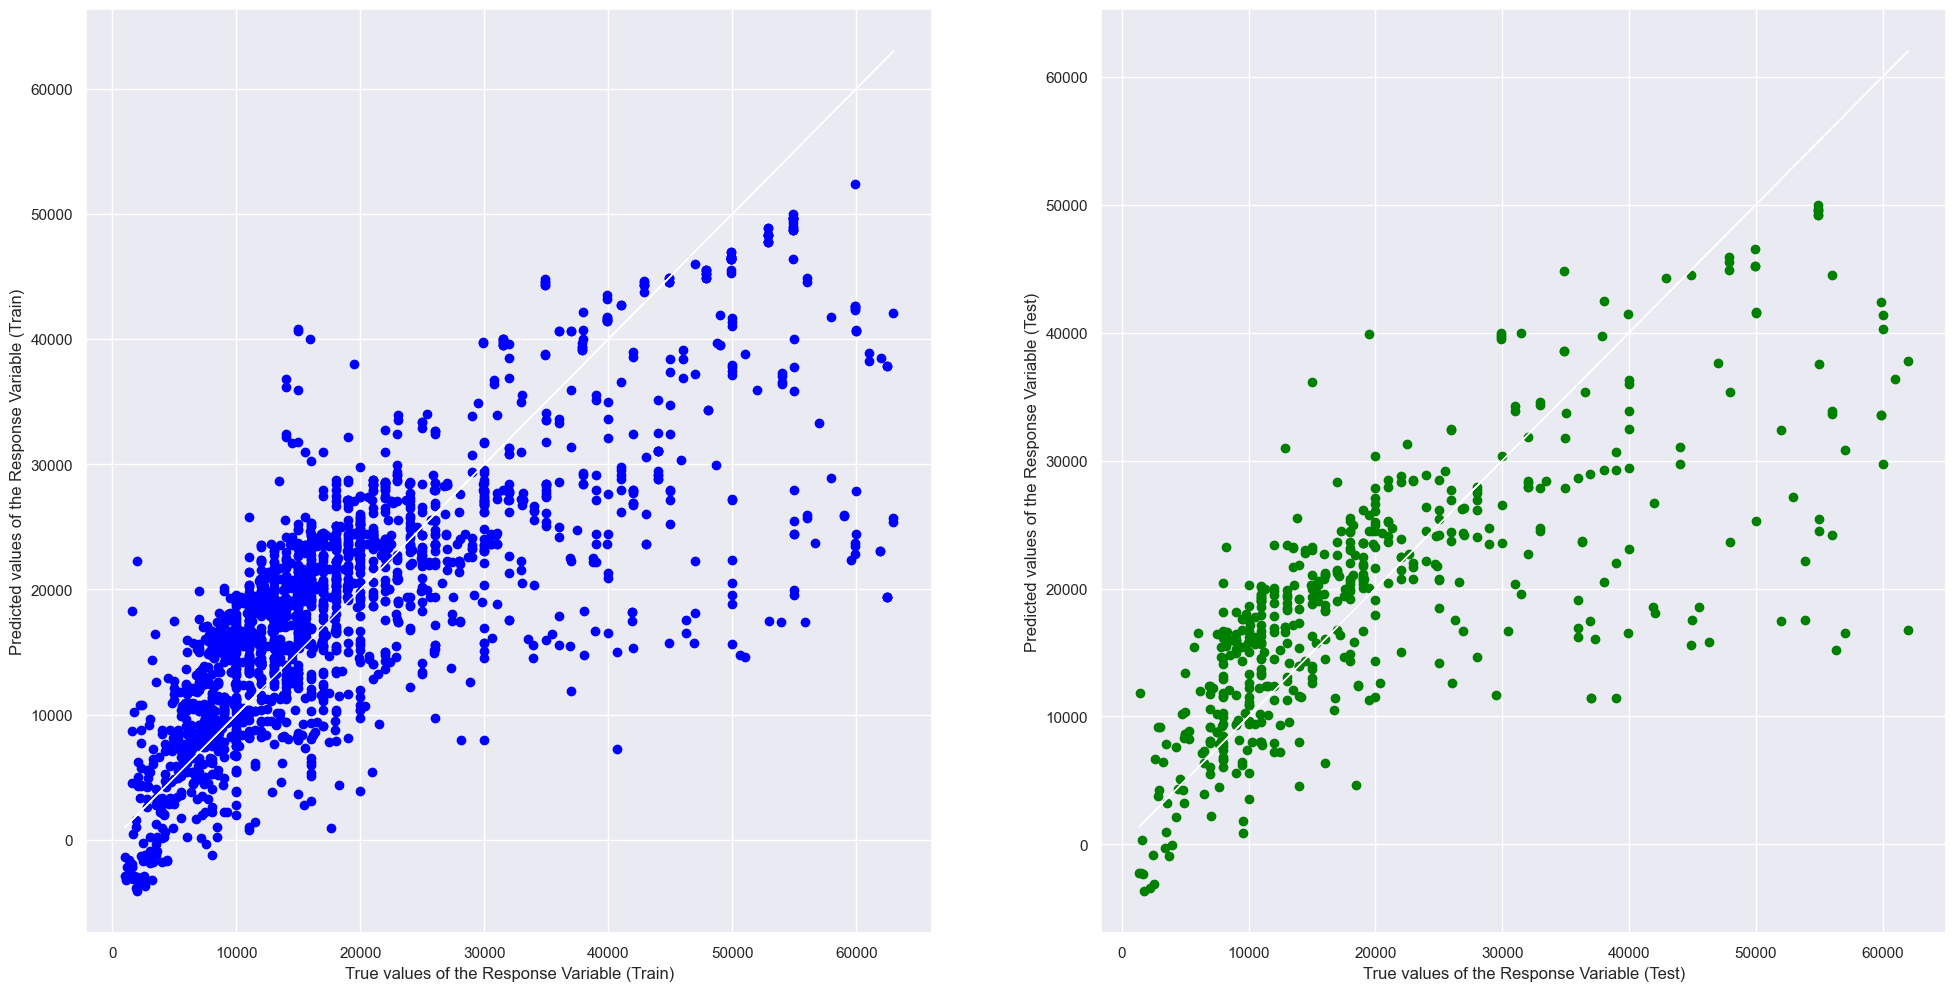

In [107]:
 # Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [108]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.59096720759079
Mean Squared Error (MSE) 	: 69434720.05399713

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5483861989784029
Mean Squared Error (MSE) 	: 89156510.33622919



## Multi-Variate Linear Regression

We will start by setting up a Multi-Variate Linear Regression problem. 

Response Variable : **Original Price**     
Predictor Feature : **Memory, Storage, Rating**       

> Regression Model : Total = $a_1$ $\times$ Memory + $a_2$ $\times$ Storage + $a_3$ $\times$ Rating + $b$  

Extract the variables and the associated data as a Pandas `DataFrame`.

In [109]:
#Create a new dataframe
filtered_data_multi_var_linreg = pd.concat([filtered_data_num, originalPrice], 
                           sort = False, axis = 1).reindex(index=filtered_data_num.index)

print(filtered_data_multi_var_linreg)

      Memory  Storage  Rating  Original Price
0      8.000  128.000     4.3           20999
1      2.000   16.000     3.8           10199
3      4.000   64.000     4.2           12999
4      4.000   64.000     4.6           49900
5      0.008    0.016     4.0            2199
...      ...      ...     ...             ...
3107   0.512    4.000     4.0            5999
3108   0.004    0.002     4.2            2299
3109   6.000  128.000     4.4           19999
3111   2.000  128.000     4.5           44900
3113   3.000   32.000     4.2            7900

[2625 rows x 4 columns]


In [110]:
# Extract Response and Predictors
y = pd.DataFrame(filtered_data_multi_var_linreg["Original Price"])
X = pd.DataFrame(filtered_data_multi_var_linreg[["Memory", "Storage", "Rating"]])

# filtered_data_num = filtered_data[['Memory','Storage','Rating']]
# filtered_data_response = filtered_data['Original Price']

# y = filtered_data_num
# X = filtered_data_response

# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (2100, 1) (2100, 3)
Test Set  : (525, 1) (525, 3)


In [111]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [-38173.26521287]
Coefficients of Regression 	: a =  [[  390.82486703    83.69774134 11872.04795098]]



,Predictors,Coefficients
0,Memory,390.824867
1,Storage,83.697741
2,Rating,11872.047951


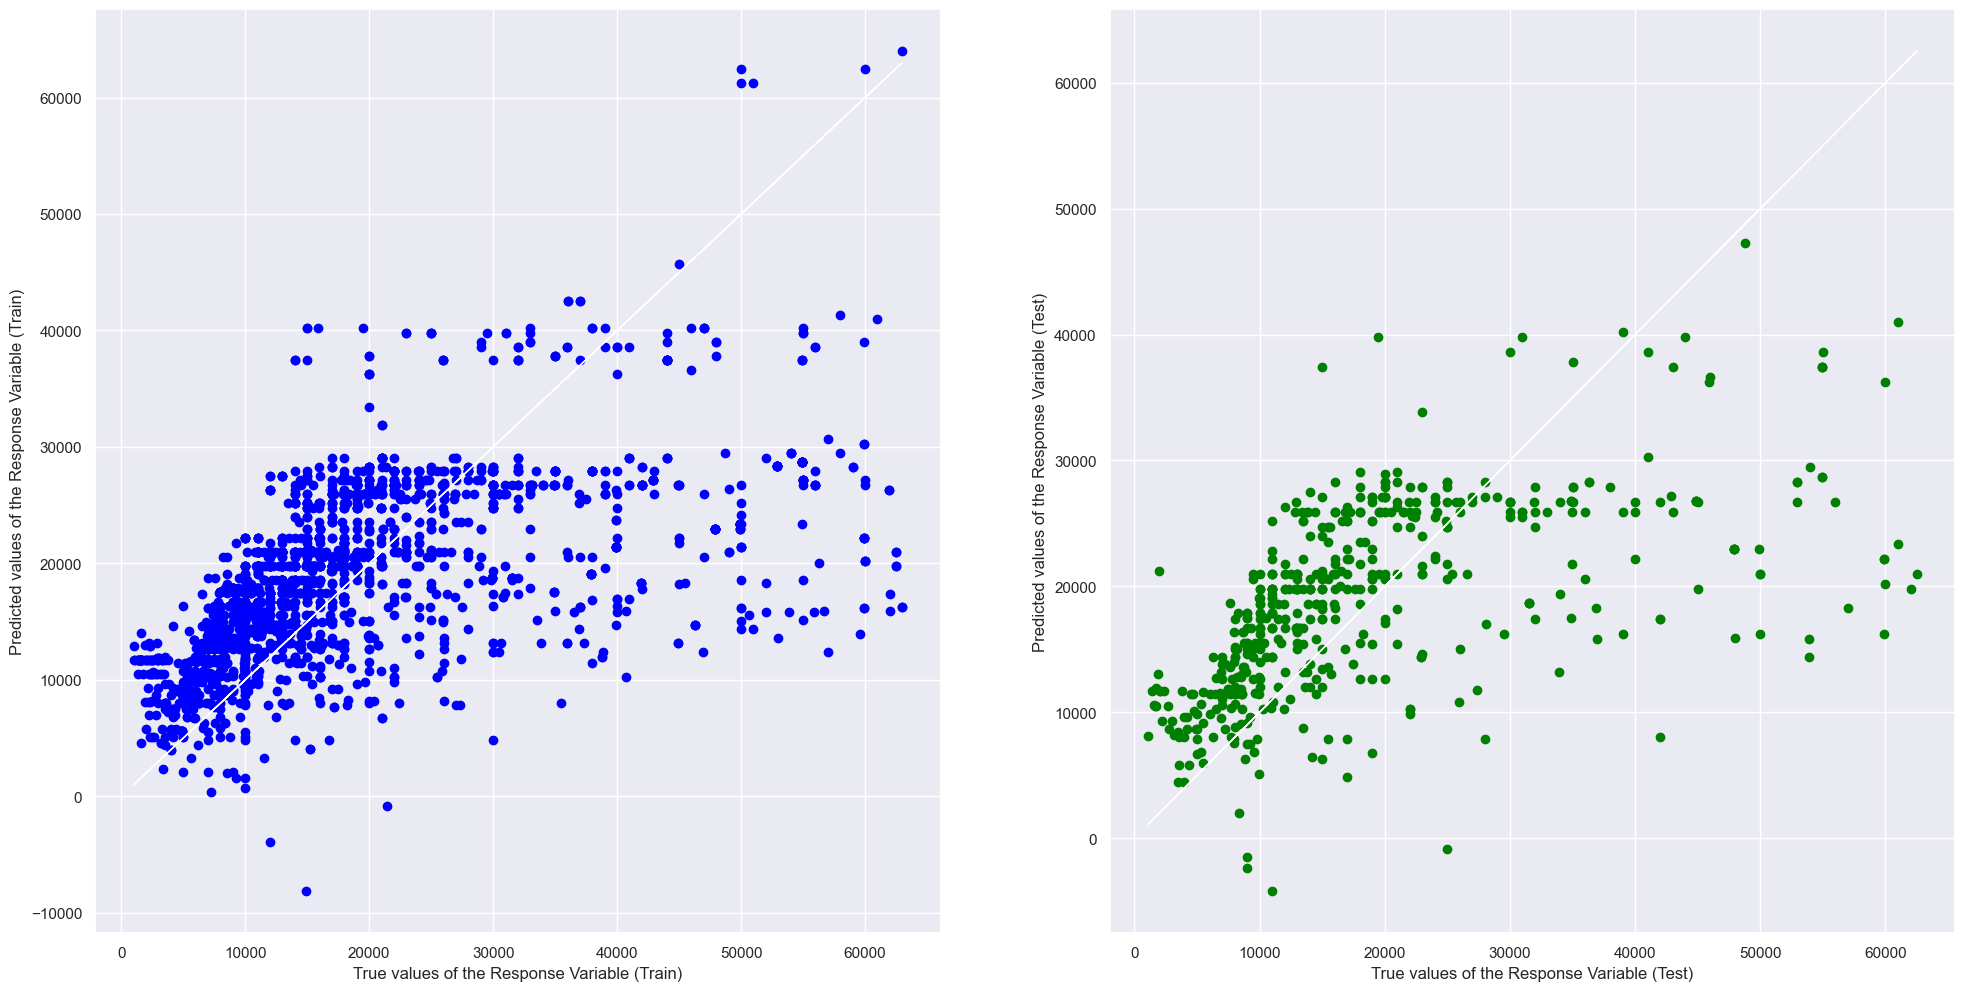

In [112]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

## Goodness of fit of the model

In [113]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.33836022854650893
Mean Squared Error (MSE) 	: 116009697.5611321

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3369830457010562
Mean Squared Error (MSE) 	: 116793758.95045695

